## NOTEBOOK INSTRUCTIONS

Here you will find an Experiments.zip folder which contains MUSE_XAE Experiments and the reproducibility notebook.
In order to successfully run the reproducibility notebook, you also need to download some results taken from the paper
`Uncovering novel mutational signatures by de novo extraction with SigProfilerExtractor` from Islam et al. [[1]](https://doi.org/10.1016/j.xgen.2022.100179)


To Run the first part of the notebook where MUSE-XAE is compared with 10 other tools follow the instructions below:

Please download the following scenarios by copying and pasting the URLs into your browser or FTP client:

- Scenario_2, Scenario_4, Scenario_6, Scenario_14 from: `ftp://alexandrovlab-ftp.ucsd.edu/pub/publications/Islam_et_al_SigProfilerExtractor/Benchmark/SBS96_Scenarios_withOUT_Noise/Suggested/Medium/`
- Scenario_8 from: `ftp://alexandrovlab-ftp.ucsd.edu/pub/publications/Islam_et_al_SigProfilerExtractor/Benchmark/SBS96_Scenarios_withOUT_Noise/Suggested/Easy/`

Put all the Scenarios in a `Tool` folder and rename each subfolder as the following:

- Scenario_2 --> Scenario_1
- Scenario_6 --> Scenario_2
- Scenario_4 --> Scenario_3
- Scenario_8 --> Scenario_4
- Scenario_14 --> Scenario_5


To Run the second part where MUSE-XAE is compared with SigProfilerExtractor on the `PCAWG` and `WGS extended cohort` datasets, you have to download the two datasets and related SigProfilerExtractor folders. In particular, download the `SBS96` folder from: `ftp://alexandrovlab-ftp.ucsd.edu/pub/publications/Islam_et_al_SigProfilerExtractor/PCAWG_Reanalysis/ALL-Tissues/SBS96/`

For the `WGS extended cohort`, download the related folder from: `ftp://alexandrovlab-ftp.ucsd.edu/pub/publications/Islam_et_al_SigProfilerExtractor/Extended_Cohort_Reanalysis/WGS_Other/ALL-Tissues/`

For some specific plots, it can be useful also to download tumour PCAWG subtypes info from: `ftp://alexandrovlab-ftp.ucsd.edu/pub/publications/Islam_et_al_SigProfilerExtractor/PCAWG_Reanalysis/`

And WGS extended info from: `ftp://alexandrovlab-ftp.ucsd.edu/pub/publications/Islam_et_al_SigProfilerExtractor/Extended_Cohort_Reanalysis/WGS_Other/`

Finally, rename the path according to the notebook.

## IMPORT LIBRARIES AND FUNCTIONS

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
from PyPDF2 import PdfMerger
import matplotlib.ticker as mticker
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import linear_sum_assignment
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error,mean_absolute_error,cohen_kappa_score,matthews_corrcoef,balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
import zipfile
import os
import math
import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_metric(performance_dict, scenarios, best_methods, thresholds, metrica='F1-Score',fig_x=18,fig_y=10,save_to=None):
    
    fig, axs = plt.subplots(2, 3, figsize=(fig_x, fig_y))
    axs = axs.ravel()
    sns.set_style('whitegrid')

    _mean_scenario = {}

    for idx, scenario in enumerate(scenarios):
        metric_mean_method = {}

        for method_name, method_data in performance_dict.items():
            metric_mean_method[method_name] = []

            for thr in thresholds:
                similarity_values = pd.Series(method_data[scenario][:-1])
                real_num_elements = method_data[scenario][-1]

                TP = sum(sim_val >= thr for sim_val in similarity_values)
                FP = sum(sim_val < thr for sim_val in similarity_values)
                FN = real_num_elements - (TP)

                Precision = TP / (TP + FP + 1e-10)
                Sensitivity = TP / (TP + FN + 1e-10)
                F1_score = 2 * Precision * Sensitivity / (Sensitivity + Precision + 1e-10)

                if metrica == 'F1-Score':
                    metric_mean_method[method_name].append(F1_score)
                elif metrica == 'Precision':
                    metric_mean_method[method_name].append(Precision)
                elif metrica == 'Sensitivity':
                    metric_mean_method[method_name].append(Sensitivity)

        _mean_scenario[scenario] = metric_mean_method

        for method in best_methods:
            axs[idx].plot(thresholds, metric_mean_method[method], label=method)

        axs[idx].set_title(f'Scenario {idx+1}')
        axs[idx].set_xlabel('Cosine similarity')
        axs[idx].set_ylabel(metrica)
        axs[idx].legend()

    if len(scenarios) < len(axs):
        fig.delaxes(axs[-1])

    plt.tight_layout()
    if save_to: plt.savefig(save_to,dpi=400)
    plt.show()
    
    return _mean_scenario


def compute_cosmic_match(S,S1,columns=['SBS_MUSE-XAE','SBS_COSMIC']):
    cost = pd.DataFrame(cosine_similarity(S.T, COSMIC_sig.T))
    row_ind, col_ind = linear_sum_assignment(1 - cost)
    reoreder_sig = S.iloc[:, row_ind]
    COSMIC = COSMIC_sig.iloc[:, col_ind]
    cosmic_match = pd.DataFrame([cosine_similarity(reoreder_sig.iloc[:, i].ravel().reshape(1, -1),
                                                    COSMIC.iloc[:, i].ravel().reshape(1, -1))[0]
                                 for i in range(COSMIC.shape[1])],
                                columns=['similarity'])
    cosmic_match.insert(0, columns[0], reoreder_sig.columns)
    cosmic_match.insert(1, columns[1], COSMIC.columns)
    
    return list(cosmic_match['similarity'])


def performance_metrics(thr,cosmic_similarity,true_sig):

    TP = sum(sim_val >= thr for sim_val in cosmic_similarity)
    FP = sum(sim_val < thr for sim_val in cosmic_similarity)
    FN = true_sig - TP 

    # Precision, Sensitivity e F1 score
    Precision = TP / (TP + FP + 1e-10)
    Sensitivity = TP / (TP + FN + 1e-10)
    F1_score = 2 * Precision * Sensitivity / (Sensitivity + Precision+ 1e-10)
    
    return (Precision,Sensitivity,F1_score)


def classification_from_representation(X, y, fold=5, n_estimators=1000,save_to=None):
    
    X = np.array(X)

    skf = StratifiedKFold(n_splits=fold,shuffle=True,random_state=12)
    class_counts = Counter(y)

    class_labels_with_counts = [f"{label} (n={class_counts[label]})" for label in np.unique(y)]

    mccs, cohens, b_accs = [], [], []
    confusion_mat_sum = np.zeros((len(np.unique(y)),len(np.unique(y)))) # Create an empty confusion matrix for summing
    
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
              
       y_train = y[train_index]
       y_test = y[test_index]
       X_train = X[train_index]
       X_test = X[test_index]
       
       RF = RandomForestClassifier(n_estimators=n_estimators, class_weight='balanced',random_state=12)
       RF.fit(X_train, y_train)
       y_pred = RF.predict(X_test)
       
       cohen = cohen_kappa_score(y_test, y_pred)
       mcc = matthews_corrcoef(y_test, y_pred)
       b_acc = balanced_accuracy_score(y_test, y_pred)
       
       cohens.append(cohen)
       mccs.append(mcc)
       b_accs.append(b_acc)
        
       confusion_mat = confusion_matrix(y_test, y_pred, labels=np.unique(y)) # Calculate confusion matrix for this fold
       
       confusion_mat_sum += confusion_mat # Add it to the sum
       
    # Create a heatmap from the sum of confusion matrices
    percentage_conf_mat = pd.DataFrame(confusion_mat_sum).apply(lambda x: x / sum(x), axis=1) * 100

    plt.figure(figsize=(18, 12))
    ax=sns.heatmap(percentage_conf_mat, annot=True, fmt=".0f", cmap='coolwarm',
                xticklabels=class_labels_with_counts, yticklabels=class_labels_with_counts)  # Aggiunto %% al formato per visualizzare il simbolo %
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 12)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 12)
    
    plt.xlabel("Predicted")
    plt.ylabel("True")
    # plt.title("Confusion Matrix - Tumor Types \n".format(fold))  # Rimuovi il format se non stai passando variabili
    plt.xticks(rotation=90)  # Ruota le etichette dell'asse x per evitare sovrapposizioni, se necessario
    for t in ax.texts: 
        if int(t.get_text())>0:
            t.set_text(t.get_text() + "%")
    
    
    if save_to:
        plt.tight_layout()
        plt.savefig(f'./Images/{save_to}')
    plt.show()

    print(f'BALANCE ACCURACY: {np.mean(b_accs)} +_ {np.std(b_accs)} \n')
    print(f'MCC: {np.mean(mccs)} +_ {np.std(mccs)} \n')
    print(f'KAPPA: {np.mean(cohens)} +_ {np.std(cohens)} \n')
    
    return confusion_mat_sum    
    
def stat_similarity(S,S1,columns=['SBS MUSE-XAE','SBS COSMIC']):
    
    cost=pd.DataFrame(cosine_similarity(S.T,S1.T))
    row_ind,col_ind=linear_sum_assignment(1-cost)
    reoreder_sig=S.iloc[:,row_ind]
    reoreder_sig_1=S1.iloc[:,col_ind]
    match=pd.DataFrame([cosine_similarity(reoreder_sig.iloc[:,i].ravel().reshape(1,-1),reoreder_sig_1.iloc[:,i].ravel().reshape(1,-1))[0] for i in range(reoreder_sig_1.shape[1])],columns=['Cosine Similarity'])
    match.insert(0,columns[0],reoreder_sig.columns)
    match.insert(1,columns[1],reoreder_sig_1.columns)
    
    return match.sort_values(by='Cosine Similarity',ascending=False).reset_index(drop=True)


def base_plot_signature(array, axs, ylim=1):

    color = ((0.196,0.714,0.863),)*16 + ((0.102,0.098,0.098),)*16 + ((0.816,0.180,0.192),)*16 + \
            ((0.777,0.773,0.757),)*16 + ((0.604,0.777,0.408),)*16 + ((0.902,0.765,0.737),)*16
    
    color = list(color)

    width = max(array.shape)
    x = np.arange(width)
    if axs == None:
        f,axs = plt.subplots(1,figsize=(20,10))
    bars = axs.bar(x, array, color=color,width=1.1)

    plt.ylim(0, ylim)
    plt.xlim(0, width)
    axs.set_ylabel('Frequency\n', fontsize=22)
    axs.tick_params(axis='y', labelsize=18)
    axs.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

    axs.set_xticks([])
    #plt.yticks(fontsize=30)


def plot_signature(signatures, name='DeNovo_Signatures', save_to='./'):

    index = ['A[C>A]A', 'A[C>A]C', 'A[C>A]G', 'A[C>A]T','C[C>A]A', 'C[C>A]C', 'C[C>A]G', 'C[C>A]T',
            'G[C>A]A', 'G[C>A]C', 'G[C>A]G', 'G[C>A]T', 'T[C>A]A', 'T[C>A]C', 'T[C>A]G', 'T[C>A]T',
            'A[C>G]A', 'A[C>G]C', 'A[C>G]G', 'A[C>G]T', 'C[C>G]A', 'C[C>G]C', 'C[C>G]G', 'C[C>G]T',
            'G[C>G]A', 'G[C>G]C', 'G[C>G]G', 'G[C>G]T', 'T[C>G]A', 'T[C>G]C', 'T[C>G]G', 'T[C>G]T',
            'A[C>T]A', 'A[C>T]C', 'A[C>T]G', 'A[C>T]T', 'C[C>T]A', 'C[C>T]C', 'C[C>T]G', 'C[C>T]T',
            'G[C>T]A', 'G[C>T]C', 'G[C>T]G', 'G[C>T]T', 'T[C>T]A', 'T[C>T]C', 'T[C>T]G', 'T[C>T]T',
            'A[T>A]A', 'A[T>A]C', 'A[T>A]G', 'A[T>A]T', 'C[T>A]A', 'C[T>A]C', 'C[T>A]G', 'C[T>A]T',
            'G[T>A]A', 'G[T>A]C', 'G[T>A]G', 'G[T>A]T', 'T[T>A]A', 'T[T>A]C', 'T[T>A]G', 'T[T>A]T', 
            'A[T>C]A', 'A[T>C]C', 'A[T>C]G', 'A[T>C]T', 'C[T>C]A', 'C[T>C]C', 'C[T>C]G', 'C[T>C]T',
            'G[T>C]A', 'G[T>C]C', 'G[T>C]G', 'G[T>C]T', 'T[T>C]A', 'T[T>C]C', 'T[T>C]G', 'T[T>C]T',
            'A[T>G]A', 'A[T>G]C', 'A[T>G]G', 'A[T>G]T', 'C[T>G]A', 'C[T>G]C', 'C[T>G]G', 'C[T>G]T',
            'G[T>G]A', 'G[T>G]C', 'G[T>G]G', 'G[T>G]T', 'T[T>G]A', 'T[T>G]C', 'T[T>G]G', 'T[T>G]T']

    n_signatures = signatures.shape[1]
    n_cols = 3
    n_rows = 8
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(35, 35)) # Adjust as needed
    fig.tight_layout(pad=7.0) # Adds space between subplots

    for i in range(n_rows):
        for j in range(n_cols):
            signature = i * n_cols + j

            # Ignoriamo l'ultimo plot
            if signature >= n_signatures:
                axs[i, j].axis('off') # Hide the last plot
                continue

            #sns.set_style('whitegrid')
            base_plot_signature(signatures.loc[index].values[:, signature], axs=axs[i, j], ylim=0.5)

            l1 = mpatches.Patch(color=(0.196, 0.714, 0.863), label='C>A')
            l2 = mpatches.Patch(color=(0.102, 0.098, 0.098), label='C>G')
            l3 = mpatches.Patch(color=(0.816, 0.180, 0.192), label='C>T')
            l4 = mpatches.Patch(color=(0.777, 0.773, 0.757), label='T>A')
            l5 = mpatches.Patch(color=(0.604, 0.777, 0.408), label='T>C')
            l6 = mpatches.Patch(color=(0.902, 0.765, 0.737), label='T>G')

            axs[i, j].set_title('MUSE-SBS' + str(number_to_letter(signature + 1))+'\n', fontsize=20, pad=20)
            axs[i, j].legend(handles=[l1, l2, l3, l4, l5, l6], loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.1),fontsize=15)
            axs[i, j].grid()
    
    plt.tight_layout()
    plt.savefig(save_to,dpi=500)
            
    plt.show()
    
def number_to_letter(number):
    return chr(64 + number)

def rename_index(index):
    if 'Ewings' in index:
        return 'Ewings/Sarcoma-bone'
    elif 'Sarcoma-bone' in index:
        return 'Ewings/Sarcoma-bone'
    else:
        return index

In [ ]:
# Unzip the Experiments folder for MUSE-XAE Experiments

import os
import zipfile
def unzip_file(zip_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

unzip_file('./Experiments.zip', './Experiments/')


## DATA AUGMENTATION RESULTS

### Varying data augmentation level observing the number of extracted profiles and their variability

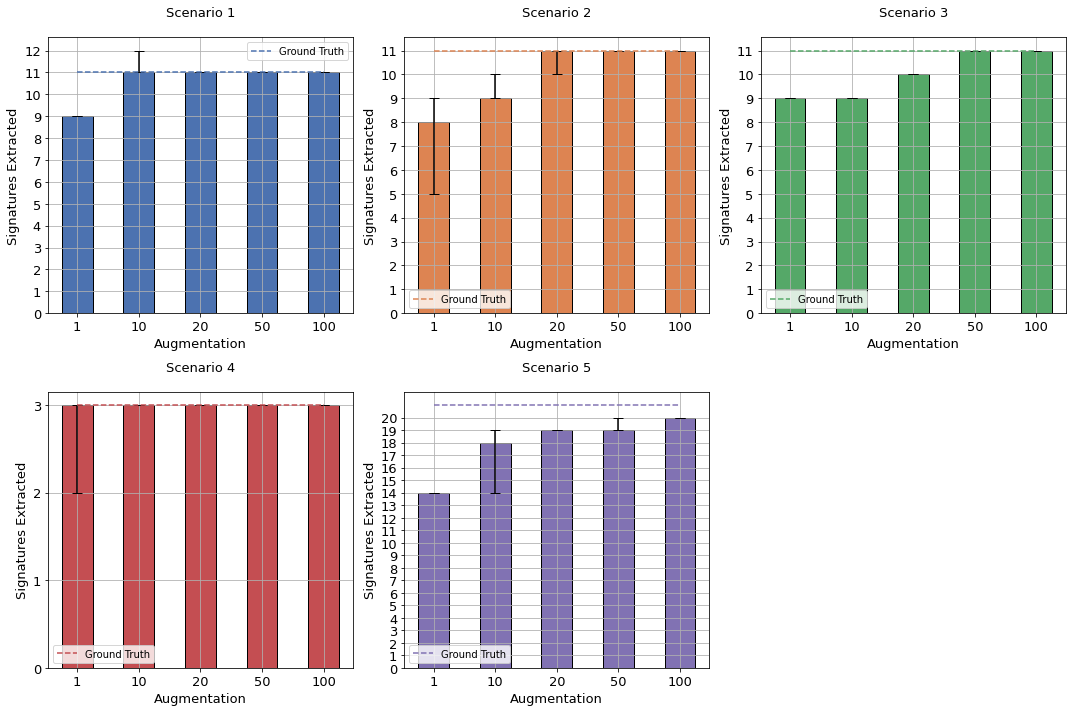

In [4]:
# synthetic scenarios were taken from Islam et. al Uncovering novel mutational signatures with SigProfilerExtractor
# the COSMIC version used was the COSMIC 3.2

COSMIC_sig=pd.read_csv('../datasets/COSMIC_SBS_GRCh37.txt',sep='\t').set_index('Type')
augmentations = [1,10,20,50,100] 

n_runs=5

all_dfs=[]
for dataset,folder in zip(['Scenario 1\n','Scenario 2\n','Scenario 3\n','Scenario 4\n','Scenario 5\n'],[1,2,3,4,5]):
    dfs=[]
    for aug in augmentations:
        runs_data = []
        for run in range(1,n_runs+1):
            length=len(pd.read_csv(f'./Experiments/augmentation_{aug}/Scenario_{folder}/Run_{run}/Suggested_SBS_De_Novo/COSMIC_match.csv'))
            runs_data.append(length)
        min_length, max_length, mean_length = min(runs_data), max(runs_data), round(np.mean(runs_data))
        df=pd.DataFrame([dataset, min_length, max_length, mean_length, aug]).T
        df.columns=['Type','Min Signatures Extracted', 'Max Signatures Extracted', 'Avg Signatures Extracted', 'Augmentation']
        dfs.append(df)
    all_dfs.append(pd.concat(dfs))


data=pd.concat(all_dfs)

types = data['Type'].unique()
colors = sns.color_palette(palette='deep')

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
axs = axs.ravel()

ground_truth = [11, 11, 11,3,21]

for i, t in enumerate(types):
    df = data[data['Type'] == t]
    axs[i].bar(df['Augmentation'].astype(str), df['Avg Signatures Extracted'], color=colors[i], width=0.5, 
               yerr=[df['Avg Signatures Extracted']-df['Min Signatures Extracted'], df['Max Signatures Extracted']-df['Avg Signatures Extracted']],
               capsize=5,edgecolor='black')
    axs[i].plot(df['Augmentation'].astype(str), [ground_truth[i]]*len(df), '--', color=colors[i], label='Ground Truth')
    axs[i].set_title(t,fontsize=13)
    axs[i].set_xlabel('Augmentation',fontsize=13)
    axs[i].set_ylabel('Signatures Extracted',fontsize=13)
    axs[i].set_yticks(np.arange(0, df['Max Signatures Extracted'].max() + 1, 1))
    axs[i].tick_params(axis='x', labelsize=13)  # for xticks
    axs[i].tick_params(axis='y', labelsize=13)  # for yticks
    axs[i].legend()
    axs[i].grid()

for i in range(len(types), len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
#plt.savefig('Images/Augmentation.pdf',dpi=400)
plt.show()

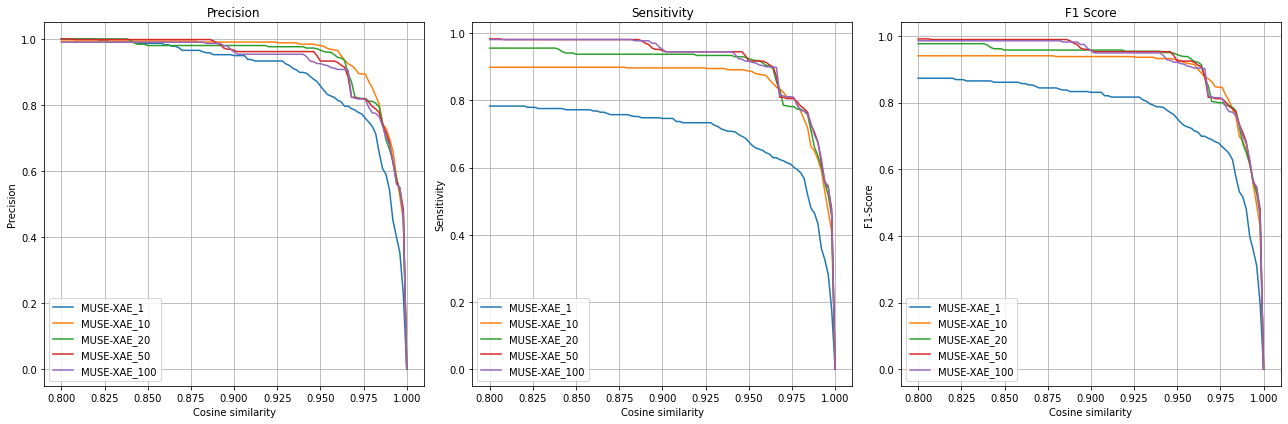

In [7]:
# MUSE XAE average performance varying data augmentation level

method_base_name = 'MUSE-XAE_'

scenarios=['Scenario_1', 'Scenario_2', 'Scenario_3', 'Scenario_4', 'Scenario_5']

true_values=[11,11,11,3,21]

performance_dict = {}

# Threshold range
thresholds = np.linspace(0.8, 1.0, 101)

for aug in augmentations:
    method_name = f'{method_base_name}{aug}'
    performance_dict[method_name] = {}
    precision_scenario,sensitivity_scenario,f1_scenario,cosine_similarity_scenario = [],[],[],[]

    for true_sig,scenario in zip(true_values,scenarios):
        precision_runs,sensitivity_runs,f1_runs,similarity_runs  = [],[],[],[]

        for run in range(1, 6):           
            try:
                MUSE_XAE=pd.read_csv(f'./Experiments/augmentation_{aug}/{scenario}/Run_{run}/Suggested_SBS_De_Novo/MUSE_SBS.csv').set_index('Type')
            except:
                continue
                
            metodi = {method_name:MUSE_XAE}
            method_df=metodi[method_name]

            S = method_df.loc[COSMIC_sig.index]
            cosmic_similarity=compute_cosmic_match(S,COSMIC_sig)
            similarity_runs.append(cosmic_similarity)
            
            # Lists to store the metric results per run for each threshold
            precision_values,sensitivity_values,f1_values = [],[],[]

            for thr in thresholds:
                # precision,sensitivity,f1
                prec,sens,f1=performance_metrics(thr,cosmic_similarity,true_sig)
                precision_values.append(prec),sensitivity_values.append(sens),f1_values.append(f1)
            
            precision_runs.append(precision_values),sensitivity_runs.append(sensitivity_values),f1_runs.append(f1_values)
        
        # avg performance
        avg_precision = np.mean(precision_runs, axis=0) 
        avg_sensitivity = np.mean(sensitivity_runs, axis=0) 
        avg_f1 = np.mean(f1_runs, axis=0)
        
        #append for each scenario
        precision_scenario.append(avg_precision),sensitivity_scenario.append(avg_sensitivity),f1_scenario.append(avg_f1)

    precision_method = np.mean(precision_scenario, axis=0)
    sensitivity_method = np.mean(sensitivity_scenario, axis=0)
    f1_method = np.mean(f1_scenario, axis=0)
        
    performance_dict[method_name] = [precision_method, sensitivity_method, f1_method]

fig, axs = plt.subplots(1, 3, figsize=(18,6)) 

for method_name, data in performance_dict.items():
    avg_precision, avg_sensitivity, avg_f1 = data
        
    # Plot the values
    axs[0].plot(thresholds, avg_precision, label=f'{method_name}')
    axs[1].plot(thresholds, avg_sensitivity, label=f'{method_name}')
    axs[2].plot(thresholds, avg_f1, label=f'{method_name}')

axs[0].set_title('Precision')
axs[0].set_xlabel('Cosine similarity')
axs[0].set_ylabel('Precision')
axs[0].legend()
axs[0].grid()

axs[1].set_title('Sensitivity')
axs[1].set_xlabel('Cosine similarity')
axs[1].set_ylabel('Sensitivity')
axs[1].legend()
axs[1].grid()

axs[2].set_title('F1 Score')
axs[2].set_xlabel('Cosine similarity')
axs[2].set_ylabel('F1-Score')
axs[2].legend()
axs[2].grid()

plt.tight_layout()
plt.show()

# PERFORMANCE COMPARISON RESULTS

### Mean Precision, Recall, F1-score across the five synthetic scenarios

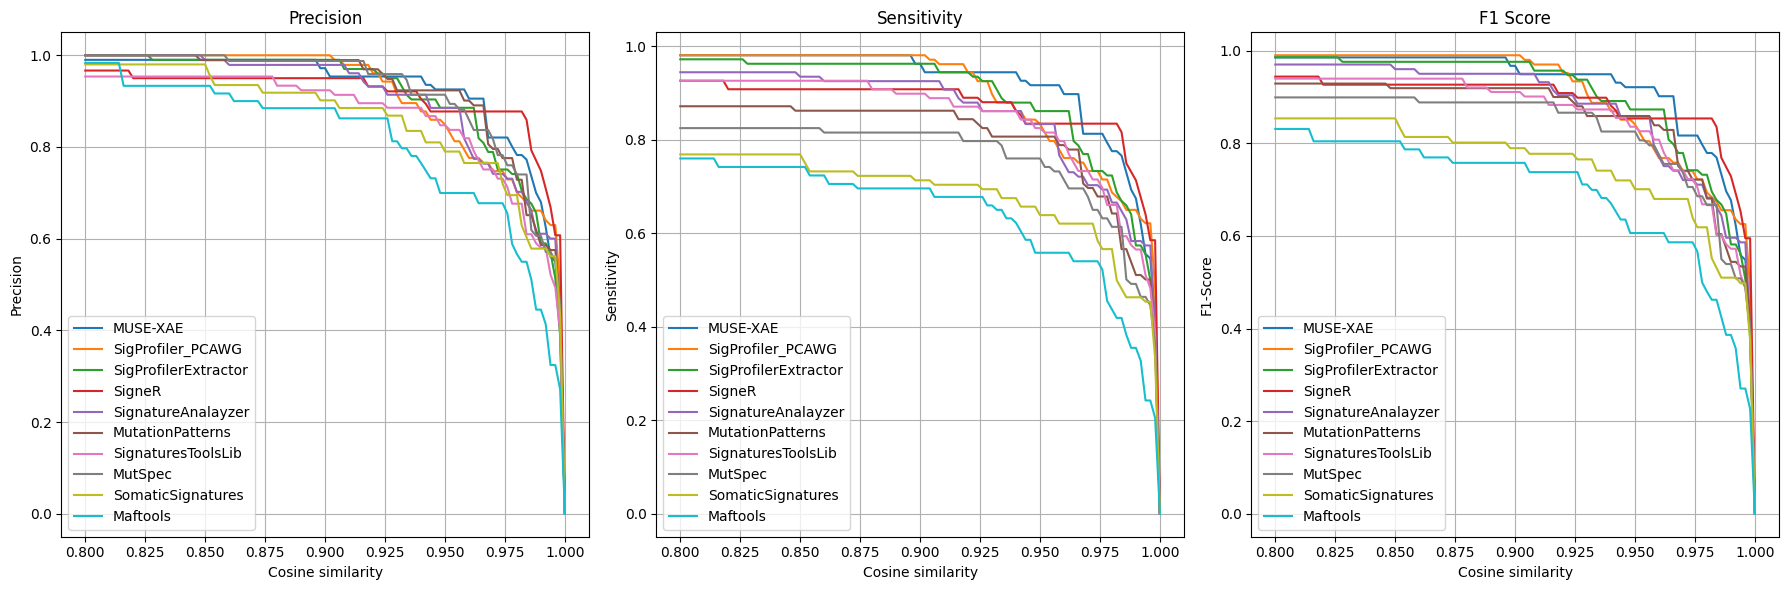

In [9]:
methods = {'Maftools','MutSpec', 'MutationPatterns','SigProfilerExtractor',
          'SignatureAnalayzer', 'SignaturesToolsLib','SigneR', 'SomaticSignatures',
          'SigProfiler_PCAWG','SigMiner','MUSE-XAE'}

scenarios = ['scenario_1', 'scenario_2', 'scenario_3', 'scenario_4', 'scenario_5']

performance_dict = {}

for method_name in methods:
    performance_dict[method_name] = {}
    
    for scenario,true_sig in zip(scenarios,true_values):
        MUSE_XAE=pd.read_csv(f'./Experiments/augmentation_100/{scenario.capitalize()}/Run_1/Suggested_SBS_De_Novo/MUSE_SBS.csv').set_index('Type')
        SigProfiler_PCAWG=pd.read_csv(f'./Tools/{scenario}/SigProfiler_PCAWG/Output/Suggested_Solution/De_Novo_Solution/De_Novo_Solution_Signatures.txt',sep='\t').set_index('MutationsType')
        Maftools=pd.read_csv(f'./Tools/{scenario}/Maftools/Output/maftools_signatures.csv').set_index('Unnamed: 0')
        MutSpec=pd.read_csv(f'./Tools/{scenario}/MutSpec/Output/signatures.txt',sep='\t')
        MutationPatterns=pd.read_csv(f'./Tools/{scenario}/MutationPatterns/Output/signatures.txt',sep='\t').set_index('MutationTypes')
        SigMiner=pd.read_csv(f'./Tools/{scenario}/SigMiner/Output/signatures.txt',sep='\t')
        SigProfilerExtractor=pd.read_csv(f'./Tools/{scenario}/SigProfilerExtractor/Output/SBS96/Suggested_Solution/SBS96_De-Novo_Solution/Signatures/SBS96_De-Novo_Signatures.txt',sep='\t').set_index('MutationsType')
        SignatureAnalayzer=pd.read_csv(f'./Tools/{scenario}/SignatureAnalyzer/GPU_Output/{scenario}_W.txt',sep='\t').set_index('Mutation Types')
        SignaturesToolsLib=pd.read_csv(f'./Tools/{scenario}/SignatureToolsLib/Output/signatures.txt',sep='\t')
        SigneR=pd.read_csv(f'./Tools/{scenario}/SigneR/Output/signatures.csv')
        SigneR.index=SigProfilerExtractor.index
        SomaticSignatures=pd.read_csv(f'./Tools/{scenario}/SomaticSignatures/Output/signatures.txt',sep='\t').set_index('Unnamed: 0')

        methods = { 'SigProfiler_PCAWG':SigProfiler_PCAWG,'Maftools': Maftools, 'MutSpec': MutSpec, 
                   'MutationPatterns': MutationPatterns,'SigProfilerExtractor': SigProfilerExtractor,
                   'SigMiner':SigMiner,'SignatureAnalayzer': SignatureAnalayzer, 'SignaturesToolsLib': SignaturesToolsLib, 
                   'SigneR': SigneR, 'SomaticSignatures': SomaticSignatures,'MUSE-XAE':MUSE_XAE}

        method_df=methods[method_name]

        
        S = method_df.loc[COSMIC_sig.index]
        cost = pd.DataFrame(cosine_similarity(S.T, COSMIC_sig.T))
        row_ind, col_ind = linear_sum_assignment(1 - cost)
        reoreder_sig = S.iloc[:, row_ind]
        COSMIC = COSMIC_sig.iloc[:, col_ind]
        cosmic_match = pd.DataFrame([cosine_similarity(reoreder_sig.iloc[:, i].ravel().reshape(1, -1),
                                                        COSMIC.iloc[:, i].ravel().reshape(1, -1))[0]
                                     for i in range(COSMIC.shape[1])],
                                    columns=['similarity'])
        cosmic_match.insert(0, 'SBS_AE', reoreder_sig.columns)
        cosmic_match.insert(1, 'SBS_COSMIC', COSMIC.columns)
        
        cosmic_similarity=list(cosmic_match['similarity'])
        cosmic_similarity.append(true_sig)
        performance_dict[method_name][scenario] = cosmic_similarity


thresholds = np.linspace(0.8, 1.0, 101)

precision_media_per_metodo = {}
sensitivity_media_per_metodo = {}
f1_media_per_metodo = {}
auc_values = {}
std_values = {}

for method_name, method_data in performance_dict.items():
    precision_media_per_metodo[method_name] = []
    sensitivity_media_per_metodo[method_name] = []
    f1_media_per_metodo[method_name] = []

    for thr in thresholds:
        precision_values = []
        sensitivity_values = []
        f1_values = []

        for scenario, data in method_data.items():
            similarity_values = pd.Series(data[:-1])
            real_num_elements = data[-1]
            
            metrics=performance_metrics(thr,similarity_values,real_num_elements)
            precision_values.append(metrics[0])
            sensitivity_values.append(metrics[1])
            f1_values.append(metrics[2])

        precision_media_per_metodo[method_name].append(np.mean(precision_values))
        sensitivity_media_per_metodo[method_name].append(np.mean(sensitivity_values))
        f1_media_per_metodo[method_name].append(np.mean(f1_values))


f1_media_globale = {method: np.mean(f1_vals) for method, f1_vals in f1_media_per_metodo.items()}

best_methods = sorted(f1_media_globale, key=f1_media_globale.get, reverse=True)[:10]

fig, axs = plt.subplots(1, 3, figsize=(18,6))  # Change here for stacking plots vertically

for method in best_methods:
    axs[0].plot(thresholds, precision_media_per_metodo[method], label=method)
    axs[1].plot(thresholds, sensitivity_media_per_metodo[method], label=method)
    axs[2].plot(thresholds, f1_media_per_metodo[method], label=method)

axs[0].set_title('Precision')
axs[0].set_xlabel('Cosine similarity')
axs[0].set_ylabel('Precision')
axs[0].legend()
axs[0].grid()

axs[1].set_title('Sensitivity')
axs[1].set_xlabel('Cosine similarity')
axs[1].set_ylabel('Sensitivity')
axs[1].legend()
axs[1].grid()

axs[2].set_title('F1 Score')
axs[2].set_xlabel('Cosine similarity')
axs[2].set_ylabel('F1-Score')
axs[2].legend()
axs[2].grid()

plt.tight_layout()
plt.show();

### F1-score,sensitvity and precision curves for each scenario

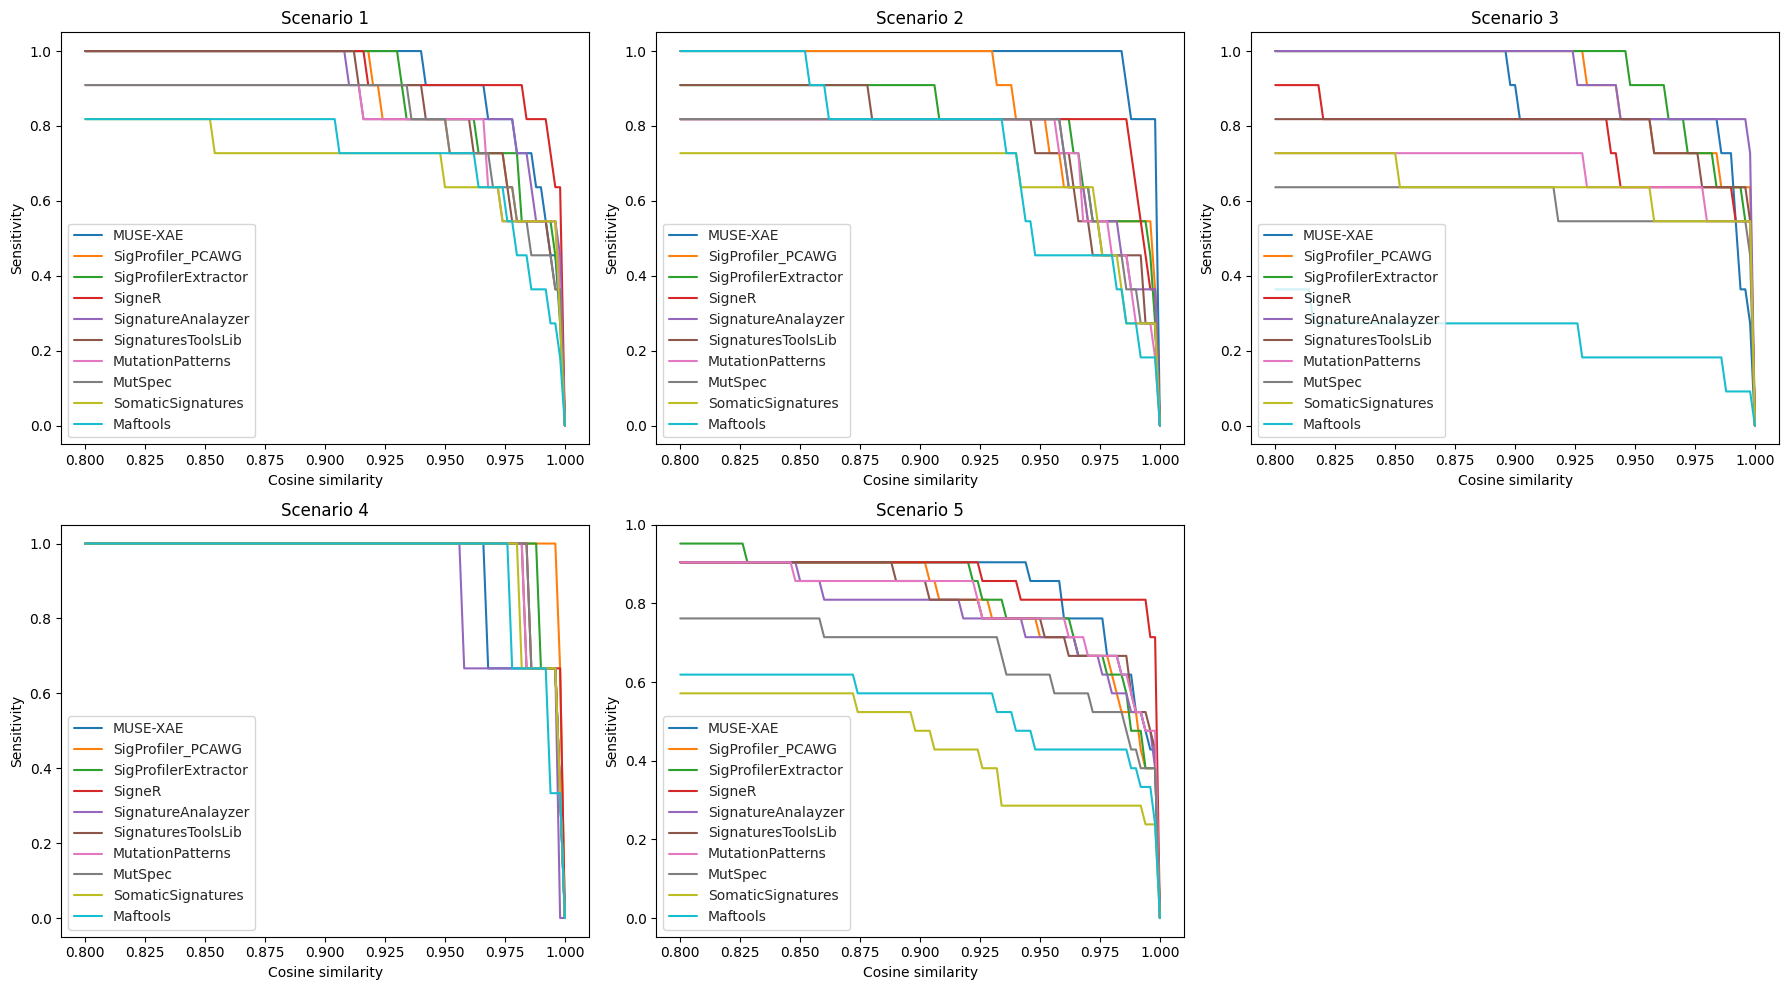

In [6]:
sensitivity_scenarios=plot_metric(performance_dict,scenarios,best_methods,thresholds,metrica='Sensitivity')

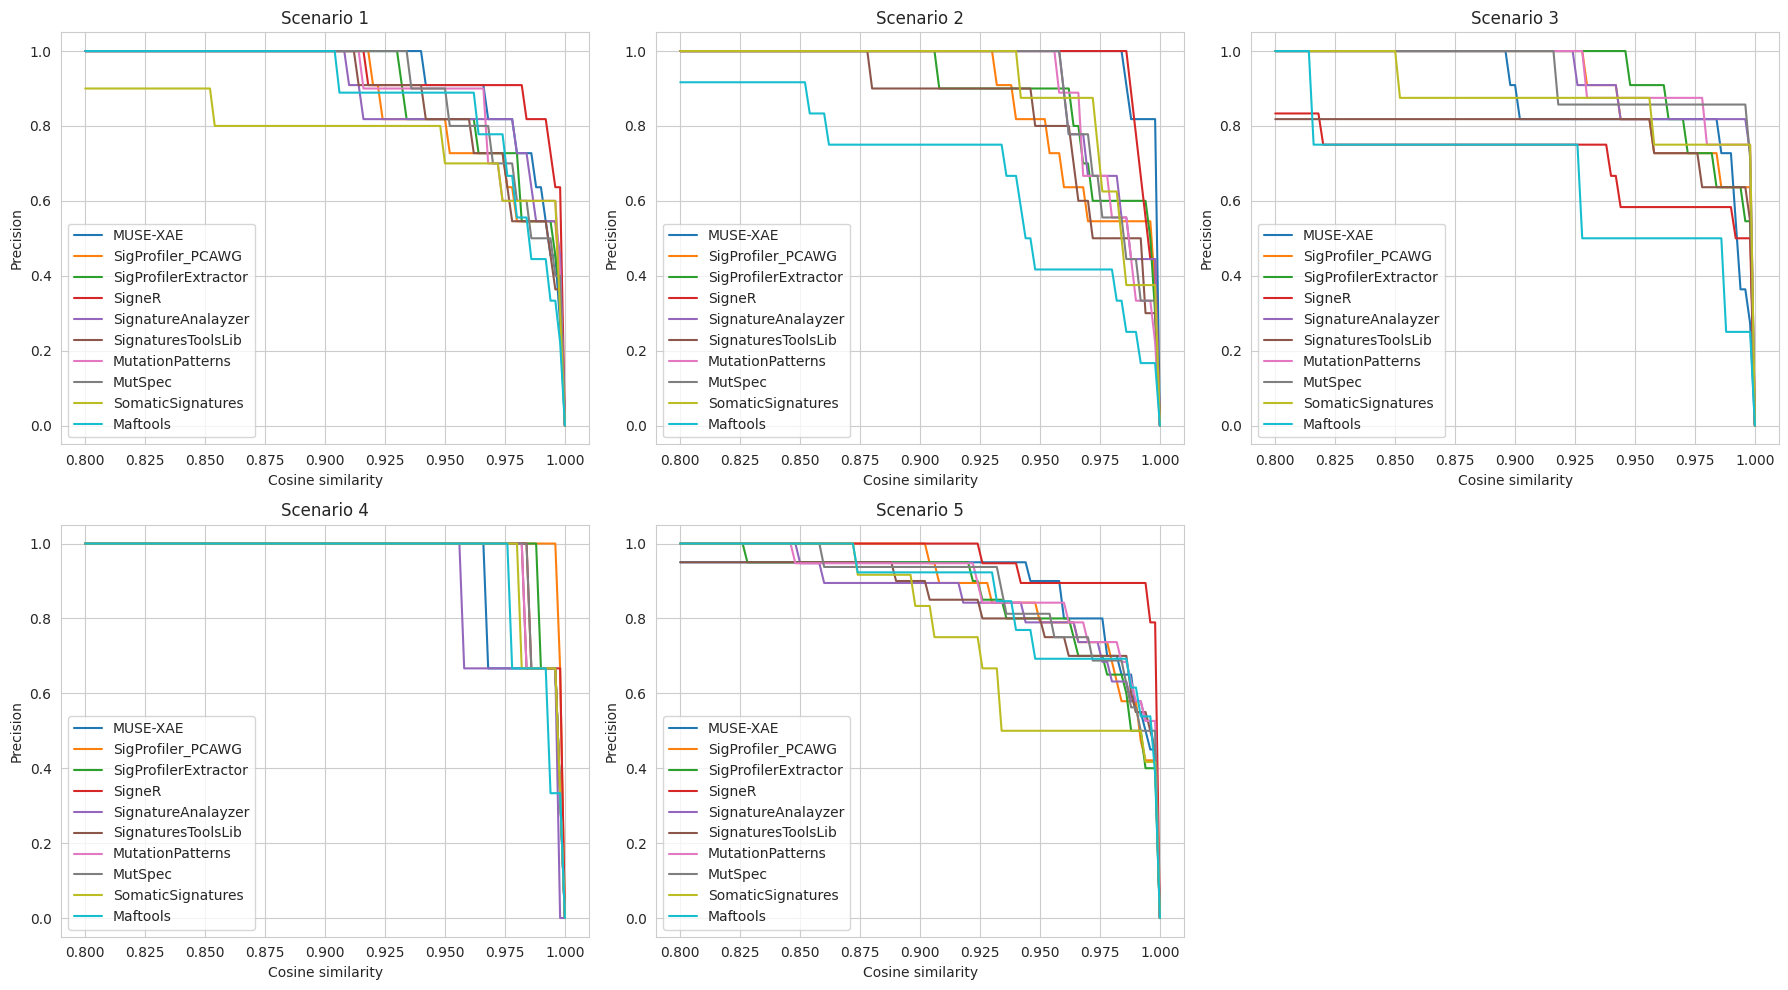

In [7]:
precision_scenarios=plot_metric(performance_dict,scenarios,best_methods,thresholds,metrica='Precision')

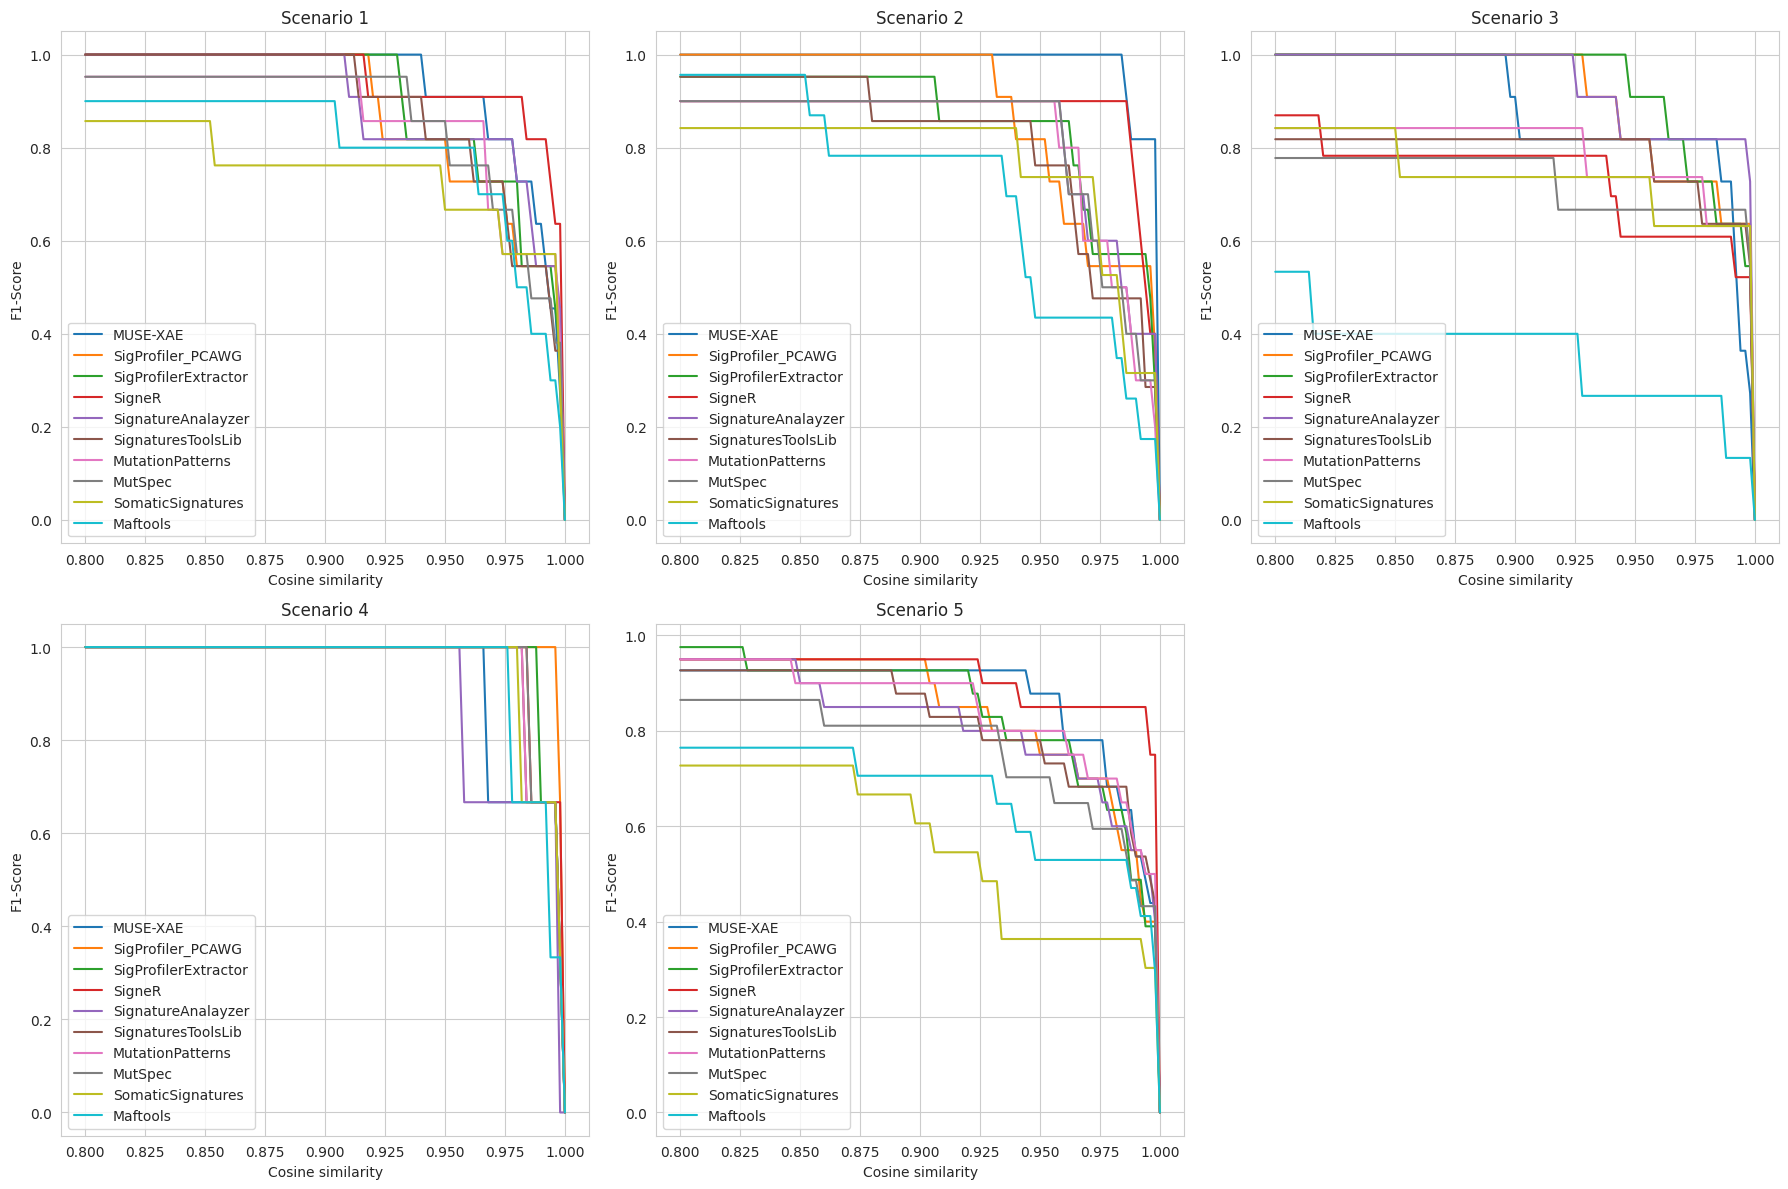

In [8]:
f1_scenarios=plot_metric(performance_dict,scenarios,best_methods,thresholds,metrica='F1-Score',fig_x=18,fig_y=12,save_to='./Images/Fig_S2.pdf')

### Mean AUC norm for F1-score

In [9]:
from sklearn.metrics import auc

df_auc_f1_tot,df_auc_precision_tot,df_auc_sensitivity_tot=[],[],[]

for scenario in scenarios:
    metodi=list(f1_scenarios[scenario])
    df_auc_f1 = pd.DataFrame(index=metodi, columns=['AUC'])
    df_auc_precision = pd.DataFrame(index=metodi, columns=['AUC'])
    df_auc_sensitivity = pd.DataFrame(index=metodi, columns=['AUC'])

    for method in metodi:
        df_auc_f1.loc[method, 'AUC'] = auc(thresholds,f1_scenarios[scenario][method])/0.2
        df_auc_precision.loc[method, 'AUC'] = auc(thresholds,precision_scenarios[scenario][method])/0.2
        df_auc_sensitivity.loc[method, 'AUC'] = auc(thresholds,sensitivity_scenarios[scenario][method])/0.2

    df_auc_f1_tot.append(df_auc_f1)
    df_auc_sensitivity_tot.append(df_auc_precision)  
    df_auc_precision_tot.append(df_auc_sensitivity)  

df_auc_f=pd.DataFrame([pd.concat(df_auc_f1_tot,axis=1).mean(axis=1).sort_values(ascending=False),pd.concat(df_auc_f1_tot,axis=1).std(axis=1).sort_values(ascending=False)]).T
df_auc_p=pd.DataFrame([pd.concat(df_auc_precision_tot,axis=1).mean(axis=1).sort_values(ascending=False),pd.concat(df_auc_precision_tot,axis=1).std(axis=1).sort_values(ascending=False)]).T
df_auc_s=pd.DataFrame([pd.concat(df_auc_sensitivity_tot,axis=1).mean(axis=1).sort_values(ascending=False),pd.concat(df_auc_sensitivity_tot,axis=1).std(axis=1).sort_values(ascending=False)]).T

In [10]:
final=pd.concat([df_auc_p,df_auc_s,df_auc_f],axis=1)
final.columns=['precision mean','precision std','sensitivity mean','sensitivity std','f1 mean','f1 std']
final 

precision mean  precision std  sensitivity mean   
MUSE-XAE                    0.916775       0.052530          0.925244  \
SigProfiler_PCAWG           0.893476       0.068729          0.910333   
SigProfilerExtractor        0.888740       0.069670          0.913264   
SigneR                      0.869351       0.089911          0.910202   
SignatureAnalayzer          0.854844       0.085101          0.904584   
SignaturesToolsLib          0.843169       0.081039          0.866732   
MutationPatterns            0.803788       0.105349          0.921494   
MutSpec                     0.759926       0.144176          0.919278   
SomaticSignatures           0.682346       0.186643          0.860133   
Maftools                    0.638779       0.266207          0.808754   
SigMiner                    0.541013       0.201685          0.850086   

                      sensitivity std   f1 mean    f1 std  
MUSE-XAE                     0.040481  0.920906  0.046077  
SigProfiler_PCAWG            0.047278  0.901483  0.056456  
SigProfilerExtractor         0.042613  0.900513  0.055324  
SigneR                       0.116628  0.887274  0.093560  
SignatureAnalayzer           0.030824  0.877635  0.054490  
SignaturesToolsLib           0.066295  0.854483  0.072264  
MutationPatterns             0.030754  0.856127  0.066479  
MutSpec                      0.034201  0.827176  0.094658  
SomaticSignatures            0.081846  0.754186  0.141898  
Maftools                     0.129779  0.694505  0.219975  
SigMiner                     0.119446  0.651661  0.191945

# PCAWG ANALYSIS

In [11]:
# define primary 18 cancer types

cancer_types = {'BLCA': 'Bladder','BOCA': 'Bone', 'BRCA': 'Breast','BTCA': 'Bladder',
    'CESC': 'Cervix','CLLE': 'Blood','CMDI': 'Blood','COAD': 'Colorectal','DLBC': 'Blood', 
    'EOPC': 'Prostate','ESAD': 'Stomach','GACA': 'Stomach','GBM': 'Brain',
    'HNSC': 'Head & Neck','KICH': 'Kidney','KIRC': 'Kidney','KIRP': 'Kidney',
    'LAML': 'Blood','LGG': 'Brain','LICA': 'Liver','LIHC': 'Liver',
    'LINC': 'Lung','LIRI': 'Liver','LUAD': 'Lung','LUSC': 'Lung',
    'MALY': 'Blood','MELA': 'Skin','ORCA': 'Head & Neck',
    'OV': 'Ovary','PACA': 'Pancreas','PAEN': 'Pancreas','PBCA': 'Brain',
    'PRAD': 'Prostate','READ': 'Colorectal','RECA': 'Kidney','SARC': 'Soft tissue',
    'SKCM': 'Skin','STAD': 'Stomach','THCA': 'Head & Neck','UCEC': 'Uterus'}

In [12]:
df_exp=pd.read_csv('./Experiments/PCAWG/Suggested_SBS_De_Novo/MUSE_EXP.csv').iloc[:,1:]
df_pcawg=pd.read_csv('./datasets/PCAWG.csv').iloc[:,1:] # you need the PCAWG datasets

types=[typ.split('-')[0] for typ in df_pcawg.columns]
df_pcawg.columns=types

df_exp['cancer_type']=df_pcawg.columns
df_exp.loc[:,'cancer_type']=df_exp.loc[:,'cancer_type'].replace(cancer_types)

## T-SNE post hoc coloured

In [13]:
scaler=MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df_exp.drop(['cancer_type'],axis=1)))

# Perform t-SNE
tsne = TSNE(random_state=5,perplexity=100,metric='euclidean')
tsne_embedding = tsne.fit_transform(df_exp.drop(['cancer_type'], axis=1))

# Create a DataFrame for the t-SNE results
tsne_result = pd.DataFrame(tsne_embedding, columns=['t-SNE1', 't-SNE2'])
tsne_result['cancer_type'] = df_exp['cancer_type']

#cancer counts and mapping
cancer_counts = df_exp['cancer_type'].value_counts().to_dict()
hue_order_with_counts = {cancer: f"{cancer} (n={count})" for cancer, count in cancer_counts.items()}
tsne_result['cancer_type_with_count'] = tsne_result['cancer_type'].map(hue_order_with_counts)

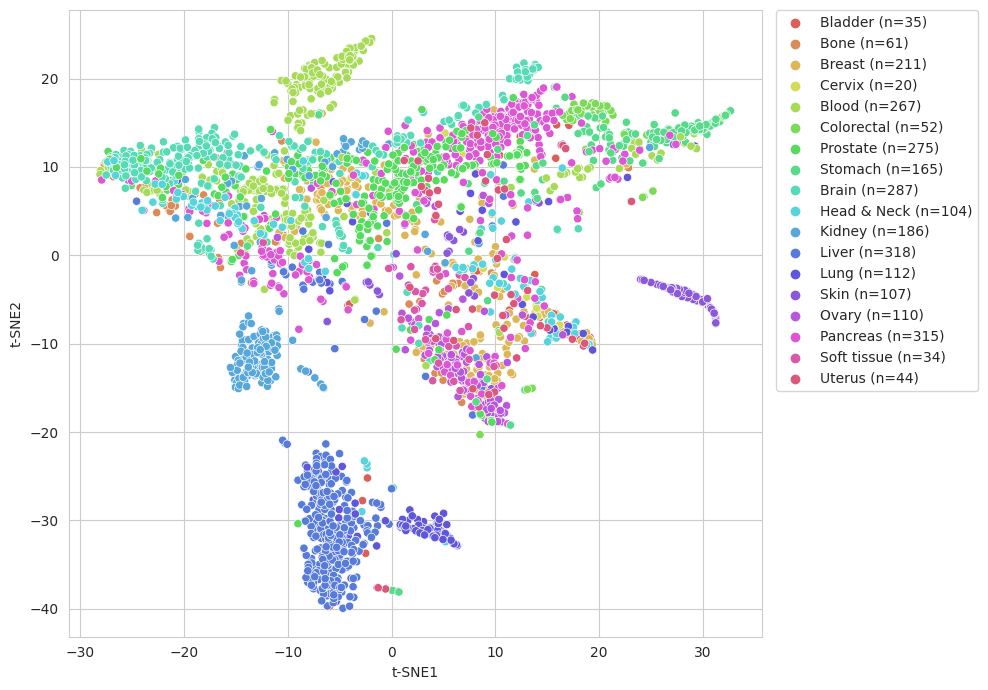

In [14]:
plt.figure(figsize=(10,7))
sns.scatterplot(
    x='t-SNE1', y='t-SNE2',
    hue='cancer_type_with_count',  
    data=tsne_result,
    palette=sns.color_palette("hls", len(set(tsne_result['cancer_type_with_count'])))
)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
#plt.savefig('./Images/TSNE_primary_types.pdf')
plt.show();

In [15]:
# define primary 37 cancer subtypes

import os

df_pcawg_sub=pd.read_csv('./datasets/PCAWG.csv').iloc[:,1:]

txt_files = [f for f in os.listdir('./datasets/tumour_subtypes/') if f.endswith('.txt')] # you need tumour_subtypes

remap={}
for txt_file in txt_files:
    # Leggere il contenuto del file .txt
    df=pd.read_csv(f'./datasets/tumour_subtypes/{txt_file}',sep='\t').iloc[:,1:].T
    tumor_name=txt_file[:-4]
    remap[tumor_name]=list(df.index)

col_remap = {}
for col in df_pcawg_sub.columns:
    for tumor_name, labels in remap.items():
        if any(label in col for label in labels):
            col_remap[col] = tumor_name
            break
    else: 
        col_remap[col] = col

df_pcawg_sub.rename(columns=col_remap, inplace=True)
df_exp['cancer_type']=df_pcawg_sub.columns

## Plotting signatures

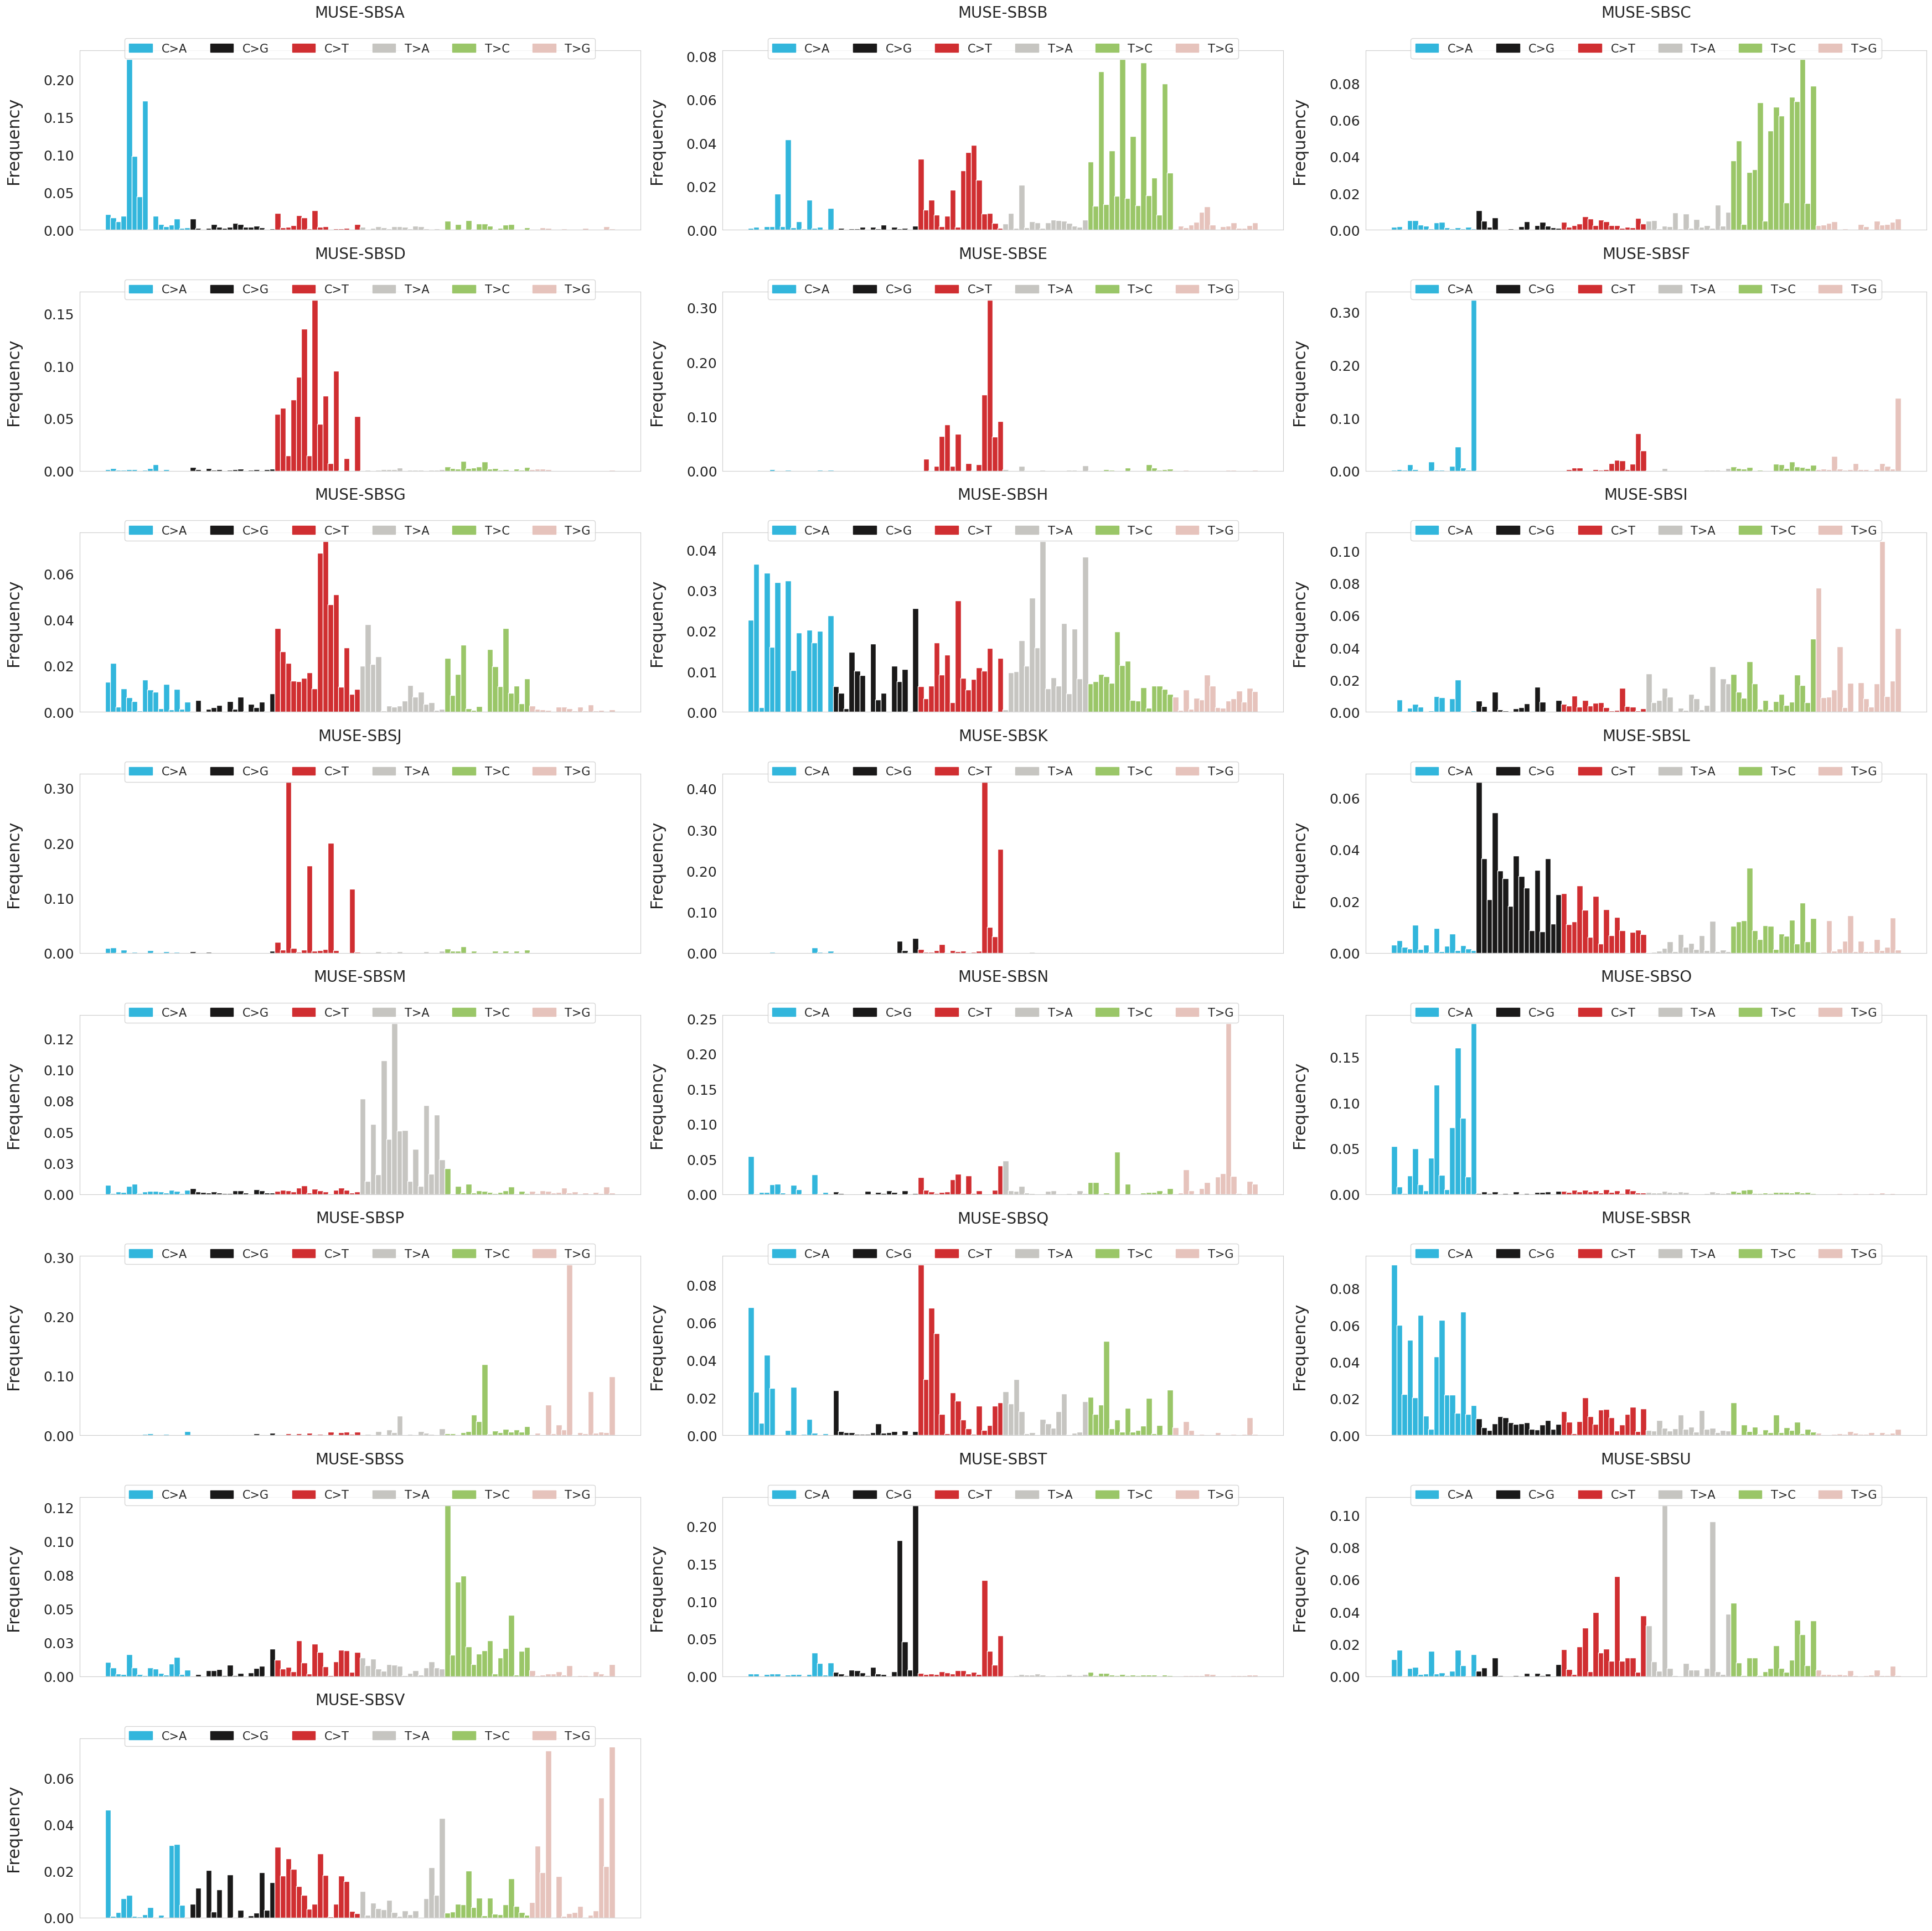

In [16]:
muse_sig=pd.read_csv('./Experiments//PCAWG//Suggested_SBS_De_Novo/MUSE_SBS.csv').set_index('Type')
plot_signature(muse_sig)

## Tumour type classification with a Random Forest Classifier

In [17]:
scaler=MinMaxScaler()

df_MUSE_XAE = pd.DataFrame(scaler.fit_transform(df_exp.drop(['cancer_type'],axis=1)))
df_MUSE_XAE['cancer_type']=df_pcawg.columns
df_MUSE_XAE['cancer_subtype']=df_pcawg_sub.columns
df_MUSE_XAE.loc[:,'cancer_type']=df_MUSE_XAE.loc[:,'cancer_type'].replace(cancer_types)

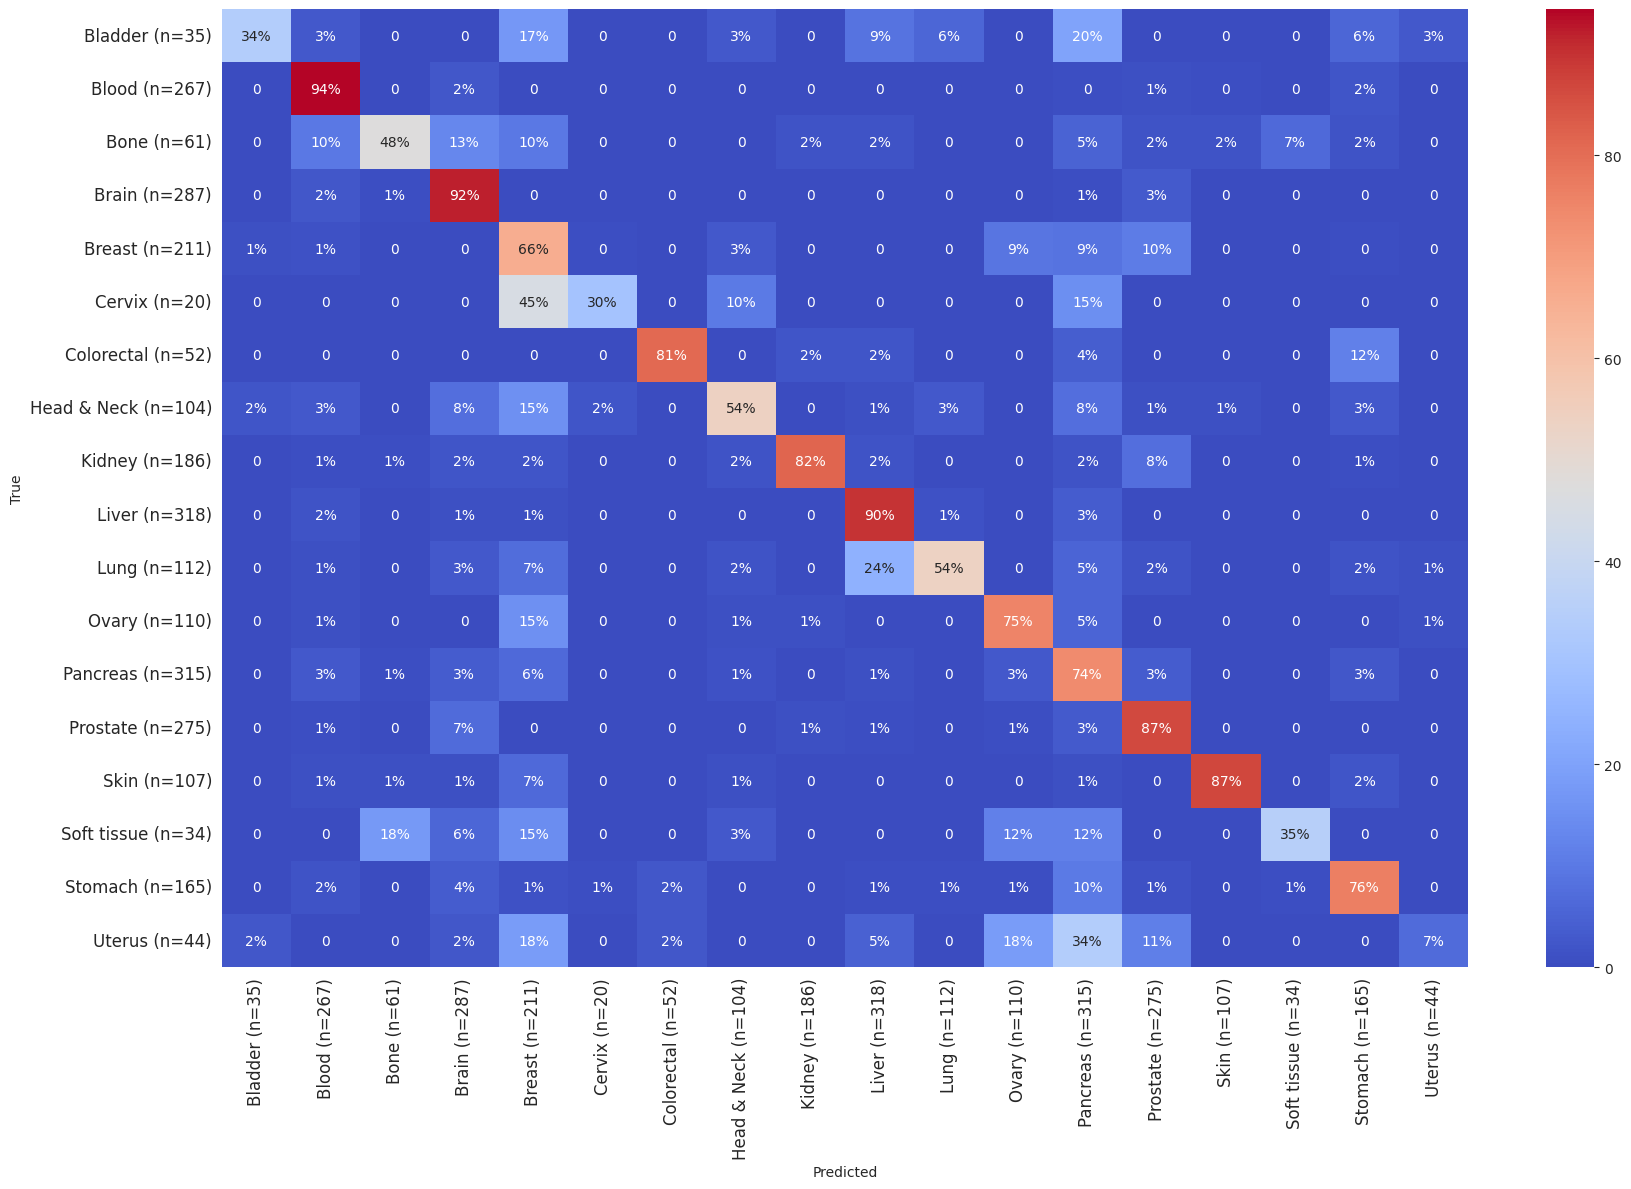

BALANCE ACCURACY: 0.6474193667051142 +_ 0.019469581033278175 

MCC: 0.7511438210311985 +_ 0.016138553873086582 

KAPPA: 0.7501658796477343 +_ 0.016253253821382097 



In [18]:
# MUSE XAE primary types classification

X=np.array(df_MUSE_XAE.set_index('cancer_type').iloc[:,:-1])
X=scaler.fit_transform(X)
y=df_MUSE_XAE['cancer_type']

conf_mat=classification_from_representation(X,y,save_to='MUSE-XAE_clf_types.pdf')

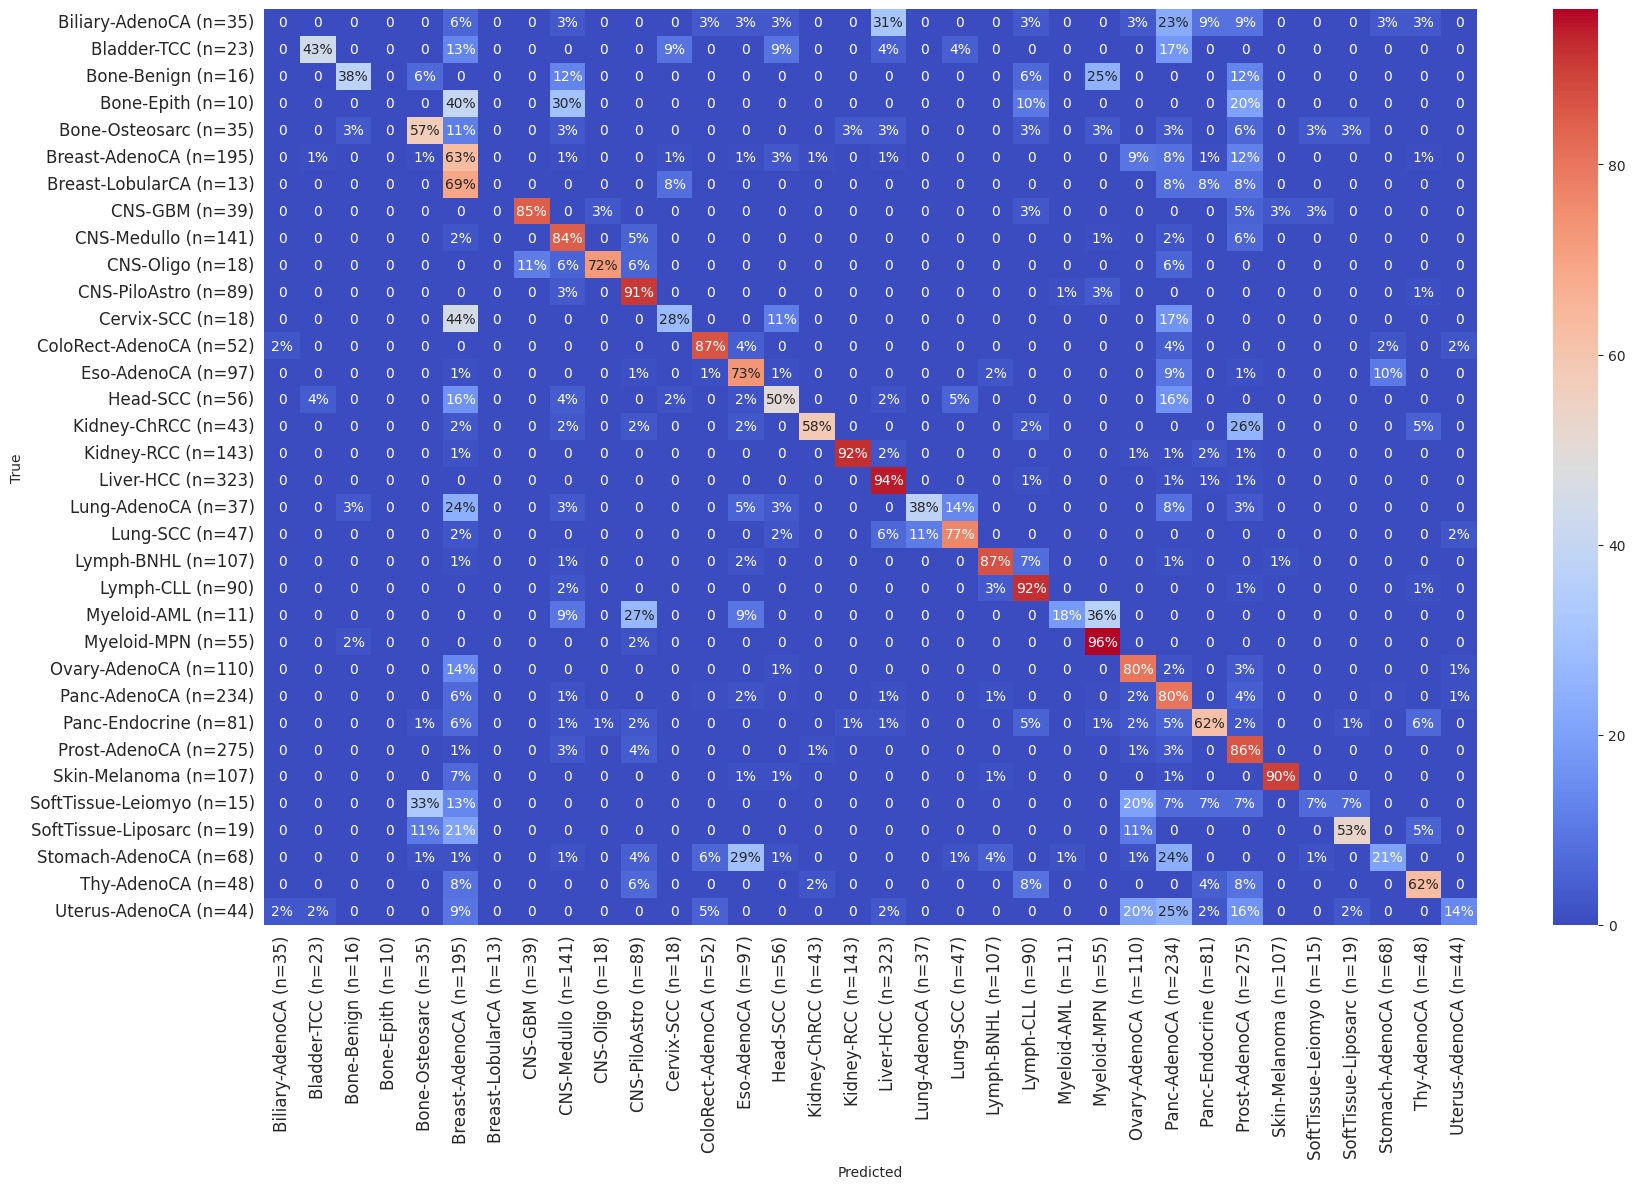

BALANCE ACCURACY: 0.5811088905861931 +_ 0.01231186637824165 

MCC: 0.7330487071394645 +_ 0.013763663550053285 

KAPPA: 0.7318325265116734 +_ 0.013966353394828403 



In [19]:
# MUSE XAE subtypes classification

X=df_MUSE_XAE.set_index('cancer_subtype').iloc[:,:-1]
X=X[X.index.value_counts()>=10]  # discard tumour types < 10
y=X.index
X=scaler.fit_transform(X)
conf_mat=classification_from_representation(X,y,save_to='MUSE-XAE_clf_subtypes.pdf')

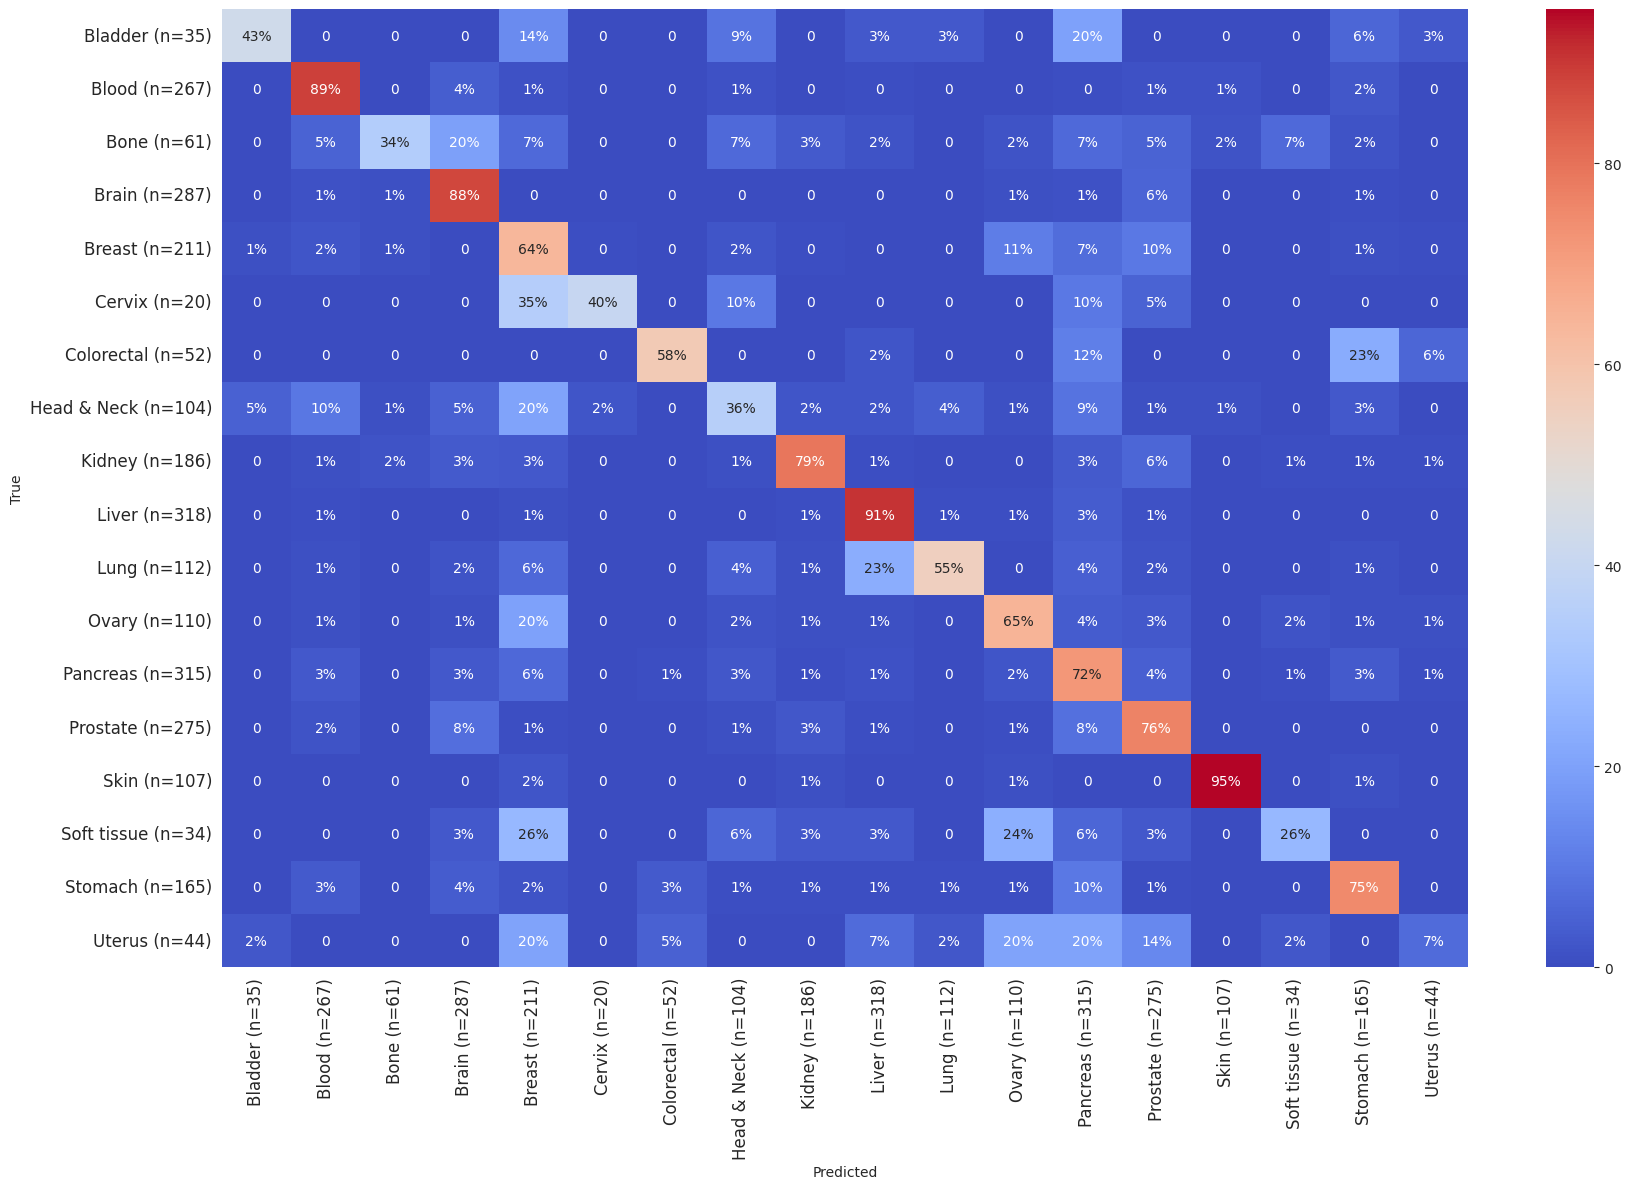

BALANCE ACCURACY: 0.6076284974555094 +_ 0.022967120992530277 

MCC: 0.7073392053595292 +_ 0.012529959104763748 

KAPPA: 0.706561797285374 +_ 0.012542129960205331 



In [20]:
# SigProfilerExtractor primary types classification

X=pd.read_csv('./Tools/SBS96_De-Novo_Activities_refit_PCAWG.txt',sep='\t').iloc[:,1:]
X=scaler.fit_transform(X)
y=df_MUSE_XAE['cancer_type']

conf_mat=classification_from_representation(X,y,save_to='SigProfiler_clf_types.pdf')

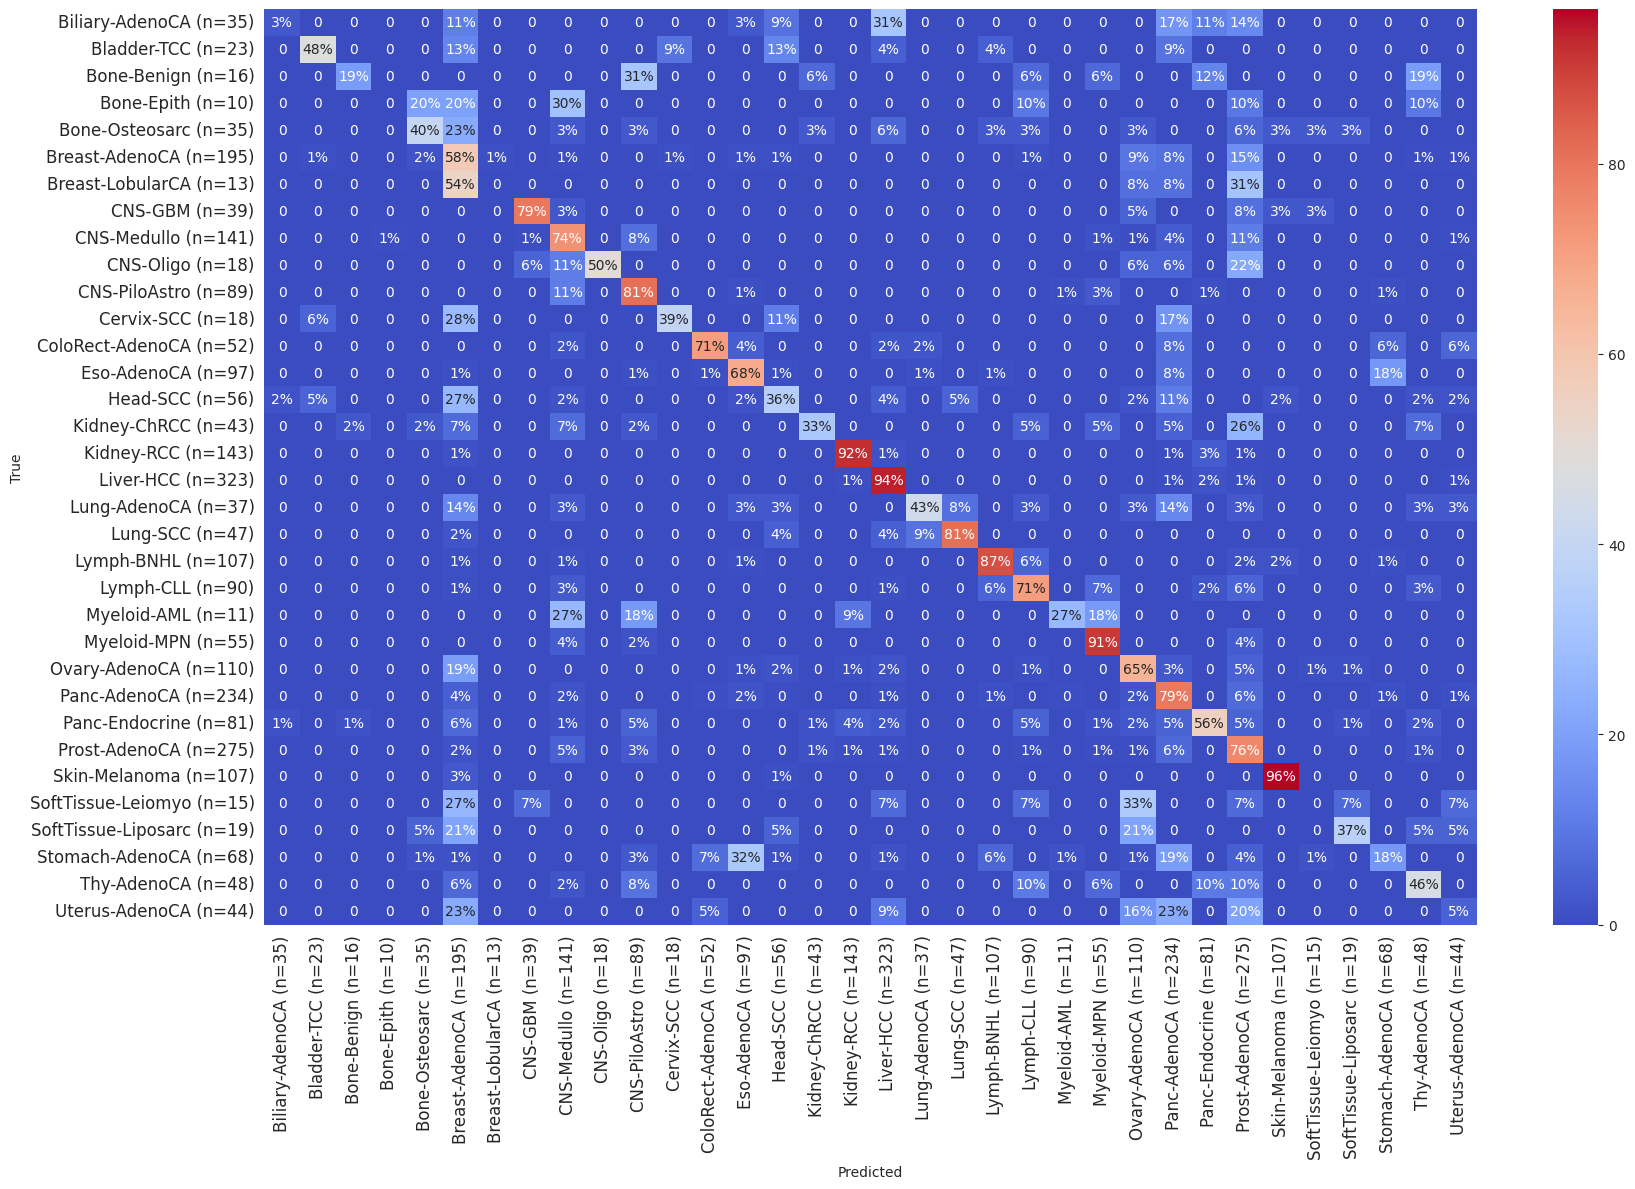

BALANCE ACCURACY: 0.5195102575584697 +_ 0.01776287580757929 

MCC: 0.6702826131222047 +_ 0.01649912284699587 

KAPPA: 0.6690487073623211 +_ 0.016650571089557028 



In [21]:
# SigProfilerExtractor subtypes classification

dataset=pd.read_csv('./Tools/SBS96_De-Novo_Activities_refit_PCAWG.txt',sep='\t').iloc[:,1:]
dataset['cancer_subtype']=list(df_MUSE_XAE['cancer_subtype'])

dataset=dataset.set_index('cancer_subtype')
X=dataset[dataset.index.value_counts()>=10]
y=X.index
X=scaler.fit_transform(X)

conf_mat=classification_from_representation(X,y,save_to='SigProfiler_clf_subtypes.pdf')

# Signatures Matching

In [22]:
COSMIC_sig=pd.read_csv('./datasets/COSMIC_SBS_GRCh37_3.4.txt',sep='\t').set_index('Type')

MUSE_sig=pd.read_csv('./Experiments//PCAWG/Suggested_SBS_De_Novo/MUSE_SBS.csv').iloc[:,1:]
SigProfiler_sig=pd.read_csv('./Tools/SigProfilerExtractor_PCAWG_analysis/Signatures/SBS96_De-Novo_Signatures.txt',sep='\t').iloc[:,1:]
Signal_sig=pd.read_csv('../MUSE_XAE_house/Signal.csv').iloc[:,2:].T.loc[COSMIC_sig.index]

In [23]:
Muse_match_cosmic=stat_similarity(MUSE_sig,COSMIC_sig,columns=['SBS MUSE-XAE','SBS COSMIC'])
Muse_match_signal=stat_similarity(MUSE_sig,Signal_sig,columns=['SBS MUSE-XAE','SBS Signal'])

In [24]:
# MUSE-XAE matched signatures with COSMIC and Signal database
# NB in the plot and in the paper signatures are called MUSE-SBS A , MUSE-SBS B etc. here we use SBS_AE_1, SBS_AE_2 and so on 

df_cosmic_signal=pd.concat([Muse_match_cosmic.set_index('SBS MUSE-XAE'),Muse_match_signal.set_index('SBS MUSE-XAE')],axis=1)
df_cosmic_signal.columns=['COSMIC','Cosmic Similarity','SIGNAL','Signal Similarity']
df_cosmic_signal.reset_index().sort_values(by='SBS MUSE-XAE')

SBS MUSE-XAE  COSMIC  Cosmic Similarity  SIGNAL  Signal Similarity
5     MUSE-SBSA   SBS38           0.950951      33           0.923796
17    MUSE-SBSB   SBS54           0.812994      26           0.837567
16    MUSE-SBSC   SBS12           0.845198      13           0.882907
6     MUSE-SBSD   SBS23           0.931818      24           0.922298
3     MUSE-SBSE   SBS7a           0.973556       6           0.994391
8     MUSE-SBSF  SBS10a           0.904804      10           0.998999
19    MUSE-SBSG   SBS44           0.780932      34           0.798999
13    MUSE-SBSH    SBS8           0.884089       8           0.936015
15    MUSE-SBSI    SBS9           0.847818       9           0.957165
0     MUSE-SBSJ    SBS1           0.996430      46           0.992432
1     MUSE-SBSK    SBS2           0.992665       1           0.993394
12    MUSE-SBSL   SBS39           0.890106      76           0.765682
2     MUSE-SBSM  SBS22a           0.990001      23           0.995167
11    MUSE-SBSN   SBS43           0.895558      49           0.598718
4     MUSE-SBSO   SBS36           0.973249      20           0.892280
7     MUSE-SBSP  SBS17b           0.927011      18           0.990558
21    MUSE-SBSQ    SBS5           0.646082      53           0.855699
18    MUSE-SBSR   SBS29           0.790818       3           0.834602
10    MUSE-SBSS   SBS92           0.896601      17           0.950409
9     MUSE-SBST   SBS13           0.901464      14           0.987599
20    MUSE-SBSU   SBS34           0.776995      77           0.782653
14    MUSE-SBSV  SBS40b           0.858393      75           0.739551

In [25]:
# SigProfiler vs MUSE-XAE matched signatures

SigProfiler_match_Muse=stat_similarity(MUSE_sig,SigProfiler_sig,columns=['SBS MUSE-XAE','SBS SigProfilerExtractor'])
muse_ordered_sig_plot=MUSE_sig[SigProfiler_match_Muse['SBS MUSE-XAE']].T
Sigprof_ordered_sig_plot=SigProfiler_sig[SigProfiler_match_Muse['SBS SigProfilerExtractor']].T
Sigprof_ordered_sig_plot.index=pd.Series(Sigprof_ordered_sig_plot.index).apply(lambda x: x[:3]+' '+x[-1])

muse_ordered_sig_plot.index= pd.Series(muse_ordered_sig_plot.index).apply(lambda x: x.split('-')[-1])

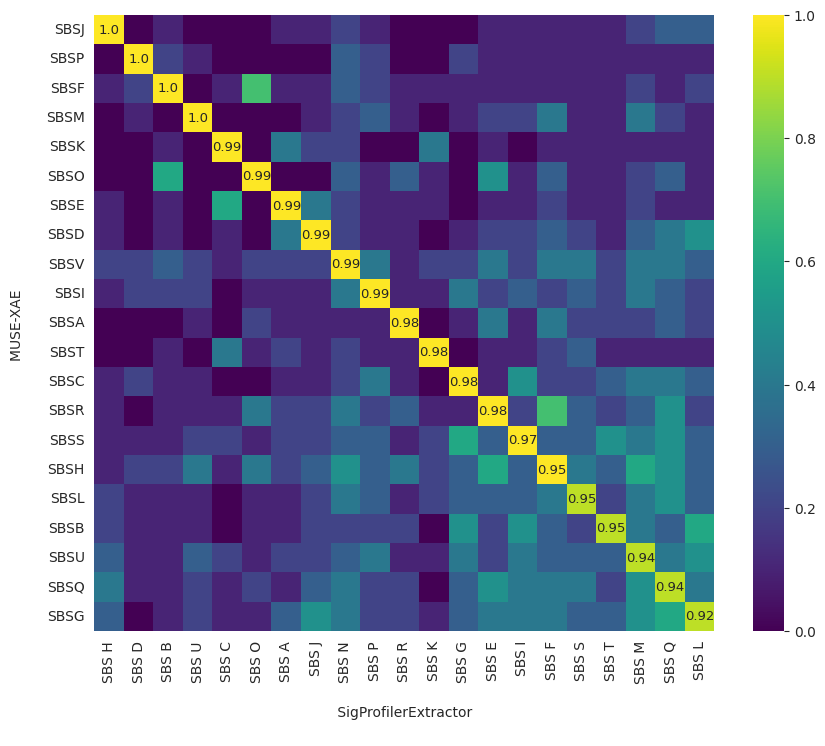

In [27]:
cosine_pcawg=np.round(cosine_similarity(muse_ordered_sig_plot,Sigprof_ordered_sig_plot),2)

plt.figure(figsize=(10,8))
ax_pcawg=sns.heatmap(np.round(cosine_similarity(muse_ordered_sig_plot,Sigprof_ordered_sig_plot),1),yticklabels=muse_ordered_sig_plot.index,xticklabels=Sigprof_ordered_sig_plot.index,cmap='viridis',annot=False);
ax_pcawg.set_xlabel('\n SigProfilerExtractor \n');
ax_pcawg.set_ylabel('MUSE-XAE \n');

for i in range(len(cosine_pcawg)):
    ax_pcawg.text(i+0.5, i+0.5, cosine_pcawg[i, i], ha='center', va='center',fontsize=9.5)

## WGS EXTENDED COHORT

In [28]:
df_extended=pd.read_csv('./datasets/WGS_extended.csv').iloc[:,1:]
df_exp_extended=pd.read_csv('./Experiments//WGS_extended//Suggested_SBS_De_Novo/MUSE_EXP.csv').iloc[:,1:]
df_exp_extended.index=df_extended.columns

In [29]:
# clean the dataset
# we discovered that sarcoma bone and ewings, even if they have different labels they share almost all samples.
# we remove the duplicates and we merge into the same category (sarcoma-bone/ewings)
# in particular starting from Ewings label (97 samples) only 6 are unique and from sarcoma Bone only 1.
# So in total we have 98 sample in the new category (sarcoma-bone/ewings)

ewings=df_extended.filter(like='Ewings').T
sarcoma_bone=df_extended.filter(like='Sarcoma-bone').T

df1=ewings.copy()
df2=sarcoma_bone.copy()

combined_df = pd.concat([df1.reset_index(drop=True), df2.reset_index(drop=True)])
sarcomabone_ewings=combined_df.drop_duplicates(keep='first')

# the first 97 belongs to ewings 
# the last to Sarcoma Bone

new_index=list(ewings.index)
new_index.append(sarcoma_bone.iloc[85,:].name)
sarcomabone_ewings.index=new_index

sarcomab_to_remove=list(sarcoma_bone.index)
sarcomab_to_remove.remove('Sarcoma-bone::IC973T_WGS')

df_exp_extended_clean=df_exp_extended[~df_exp_extended.index.isin(sarcomab_to_remove)]
df_extended_clean=df_extended.loc[:,~df_extended.columns.isin(sarcomab_to_remove)]

# extract types without code and merge Ewings/Sarcomabone
df_exp_extended_clean.index=[typ.split(':')[0] for typ in df_exp_extended_clean.index]
new_index = df_exp_extended_clean.index.map(rename_index)
df_exp_extended_clean.index = new_index
df_extended_clean.columns=df_exp_extended_clean.index

In [30]:
# primary cancer types

types_list=[]
for cancer in df_extended_clean.columns:
    if '-' in cancer: types_list.append(cancer.split('-')[0])
    else: types_list.append(cancer)

# replace subtypes with primary types

rep={'ALL':'Blood','AML':'Blood','ColoRect':'Colorectal','Eso':'Stomach','Ewings/Sarcoma':'Bone','Lymph':'Blood',
'Panc':'Pancreas','Prost':'Prostate','Biliary':'Bladder','Ovary':'Ovary','CNS':'Brain','Sarcoma':'Bone'}

extended_primary=df_extended_clean.copy()
extended_primary.columns=types_list
extended_primary=extended_primary.rename(columns=rep)

exp_extended_primary=df_exp_extended_clean.copy()
exp_extended_primary.index=extended_primary.columns

## T-SNE post hoc coloured

In [31]:
scaler=MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(exp_extended_primary))

# Perform t-SNE for the extended cohort
tsne_extended = TSNE(random_state=12,perplexity=100,metric='euclidean')
tsne_embedding_extended = tsne_extended.fit_transform(df)

# Create a DataFrame for the t-SNE results
tsne_result_extended = pd.DataFrame(tsne_embedding_extended, columns=['t-SNE1', 't-SNE2'])
tsne_result_extended ['cancer_type'] = exp_extended_primary.index

cancer_counts_extended  = exp_extended_primary.index.value_counts().to_dict()

hue_order_with_counts_extended  = {cancer: f"{cancer} (n={count})" for cancer, count in cancer_counts_extended.items()}

tsne_result_extended ['cancer_type_with_count'] = tsne_result_extended ['cancer_type'].map(hue_order_with_counts_extended)

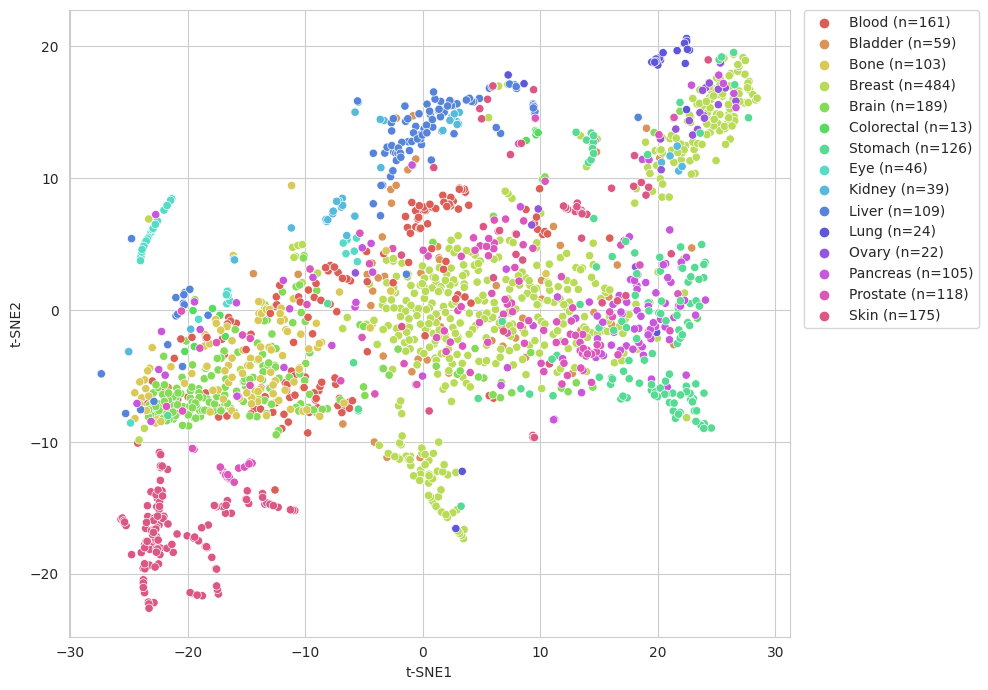

In [32]:
plt.figure(figsize=(10,7))
sns.scatterplot(
    x='t-SNE1', y='t-SNE2',
    hue='cancer_type_with_count',  
    data=tsne_result_extended,
    palette=sns.color_palette("hls", len(set(tsne_result_extended['cancer_type_with_count'])))
)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show();

## Plot signatures

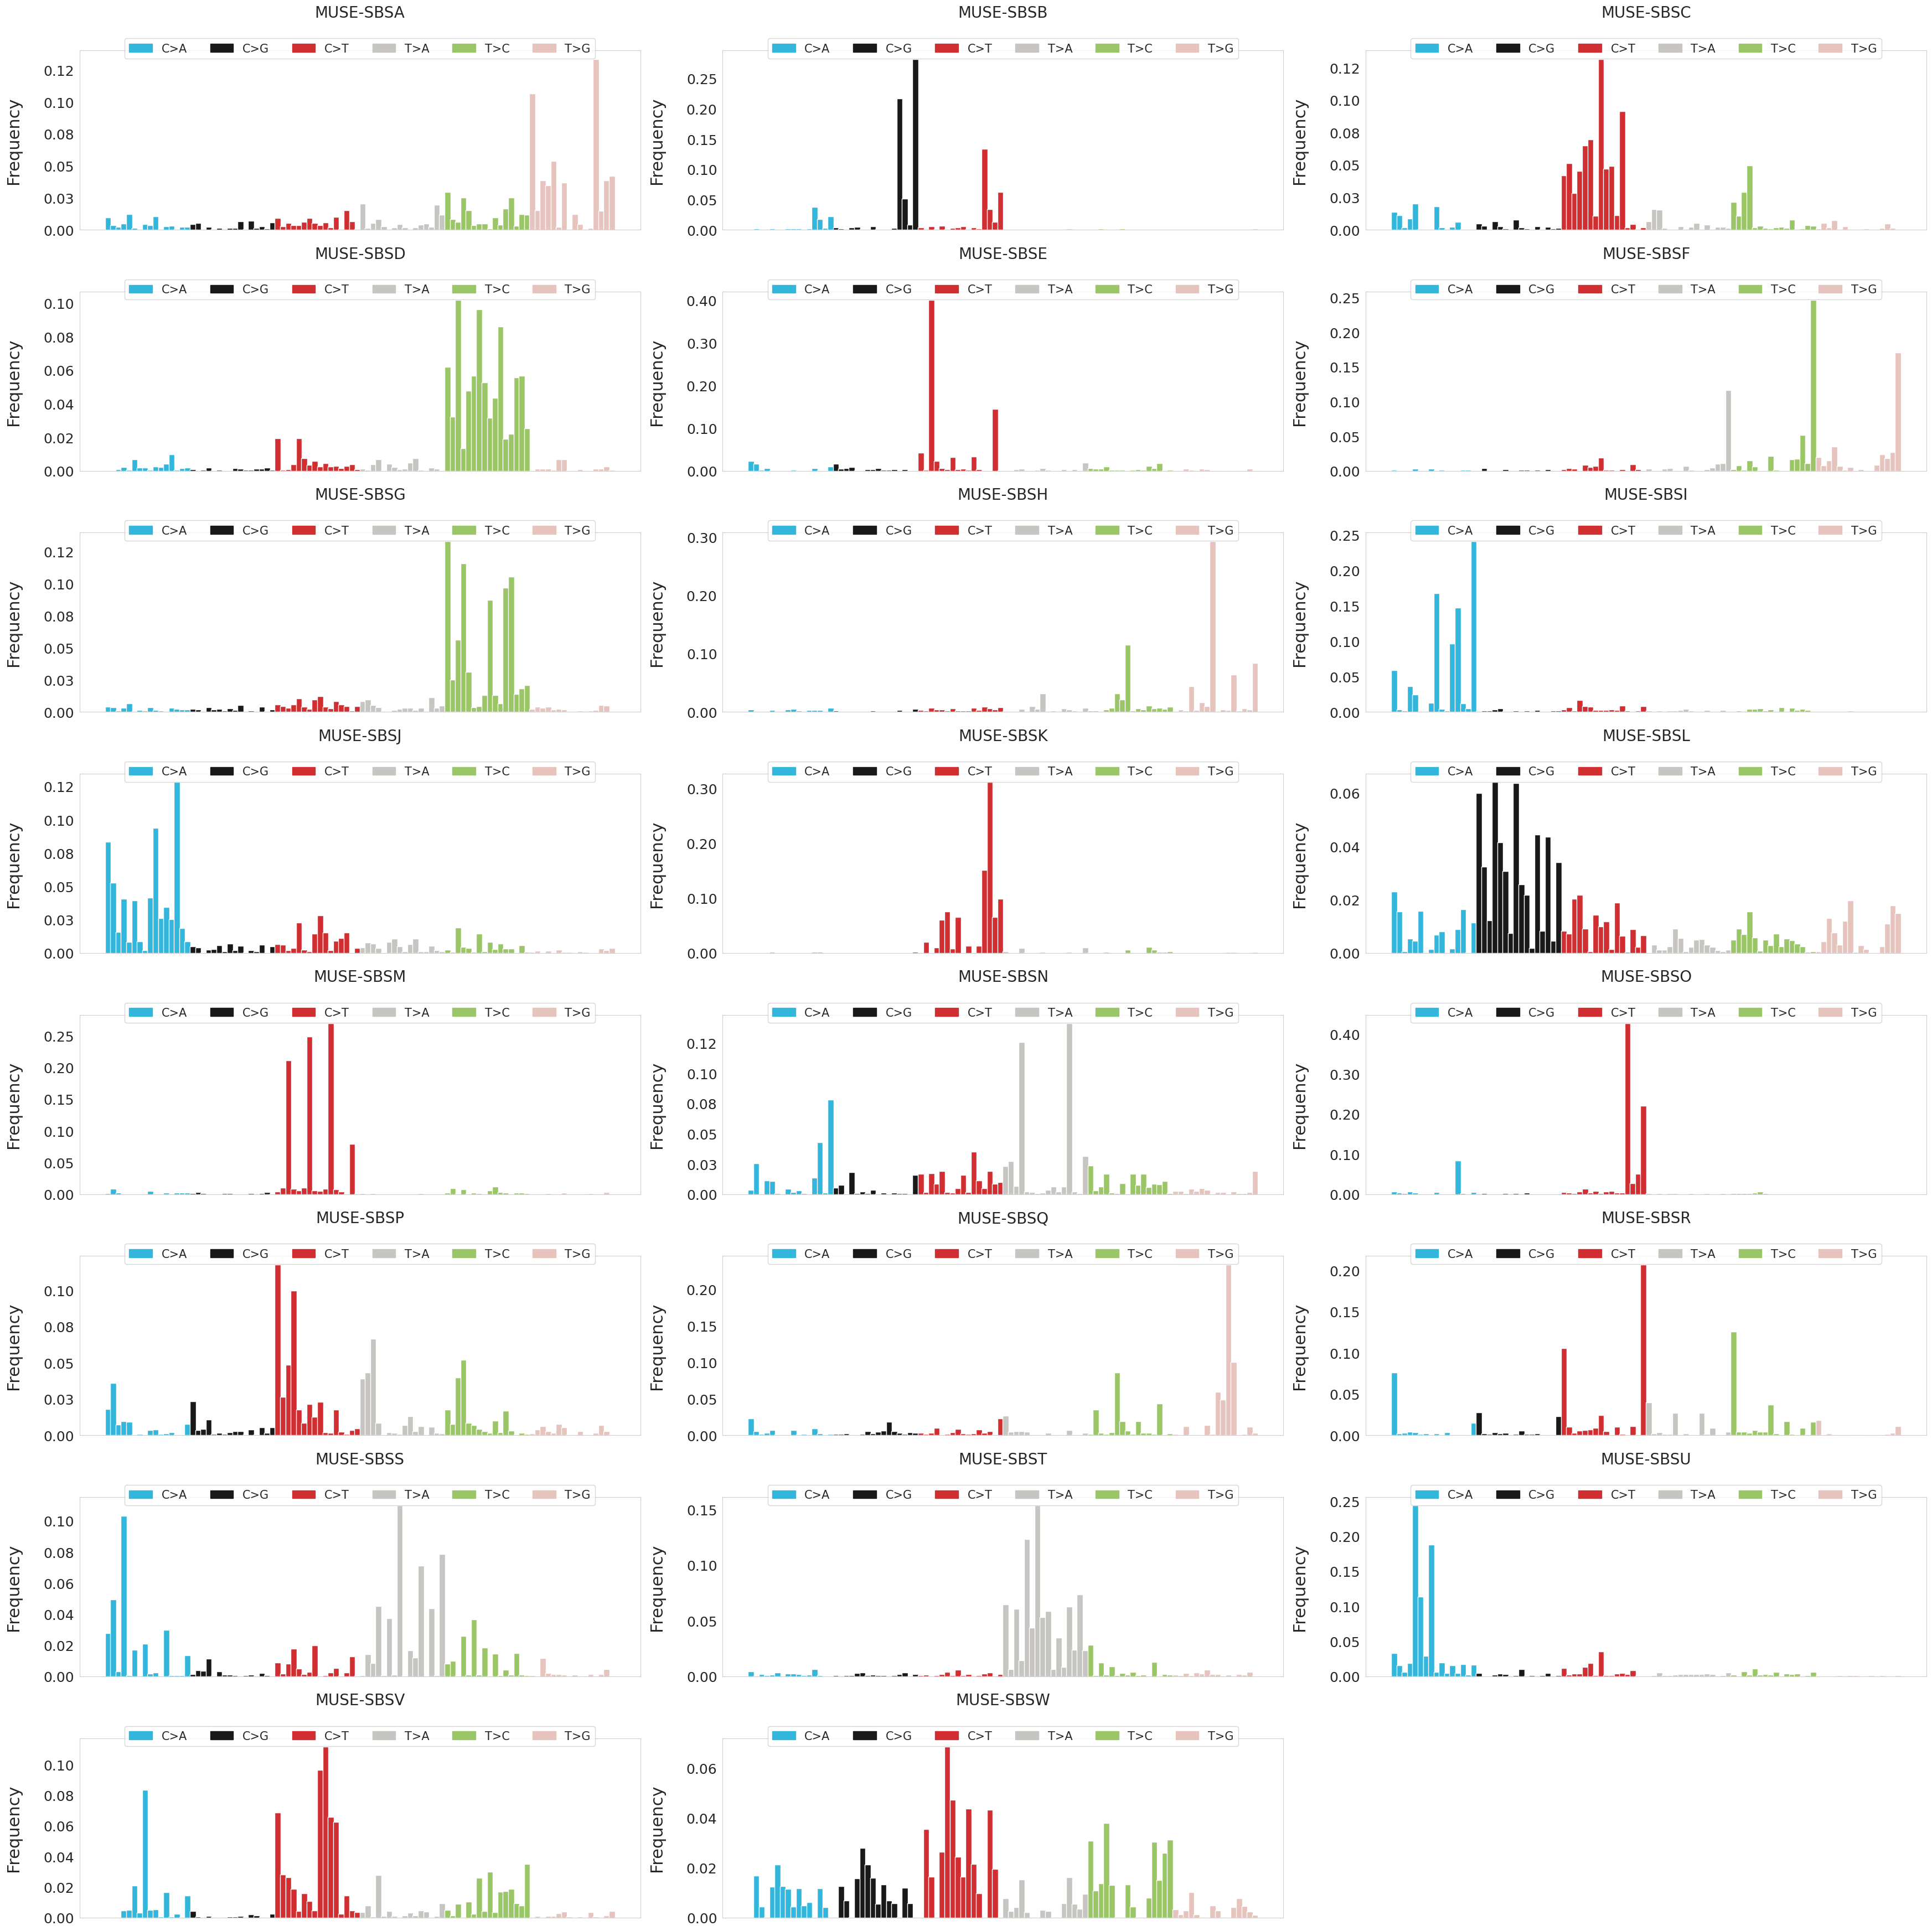

In [33]:
muse_sig_extended=pd.read_csv('Experiments//WGS_extended/Suggested_SBS_De_Novo/MUSE_SBS.csv').set_index('Type')
plot_signature(muse_sig_extended)

## Tumour type classification with a Random Forest Classifier

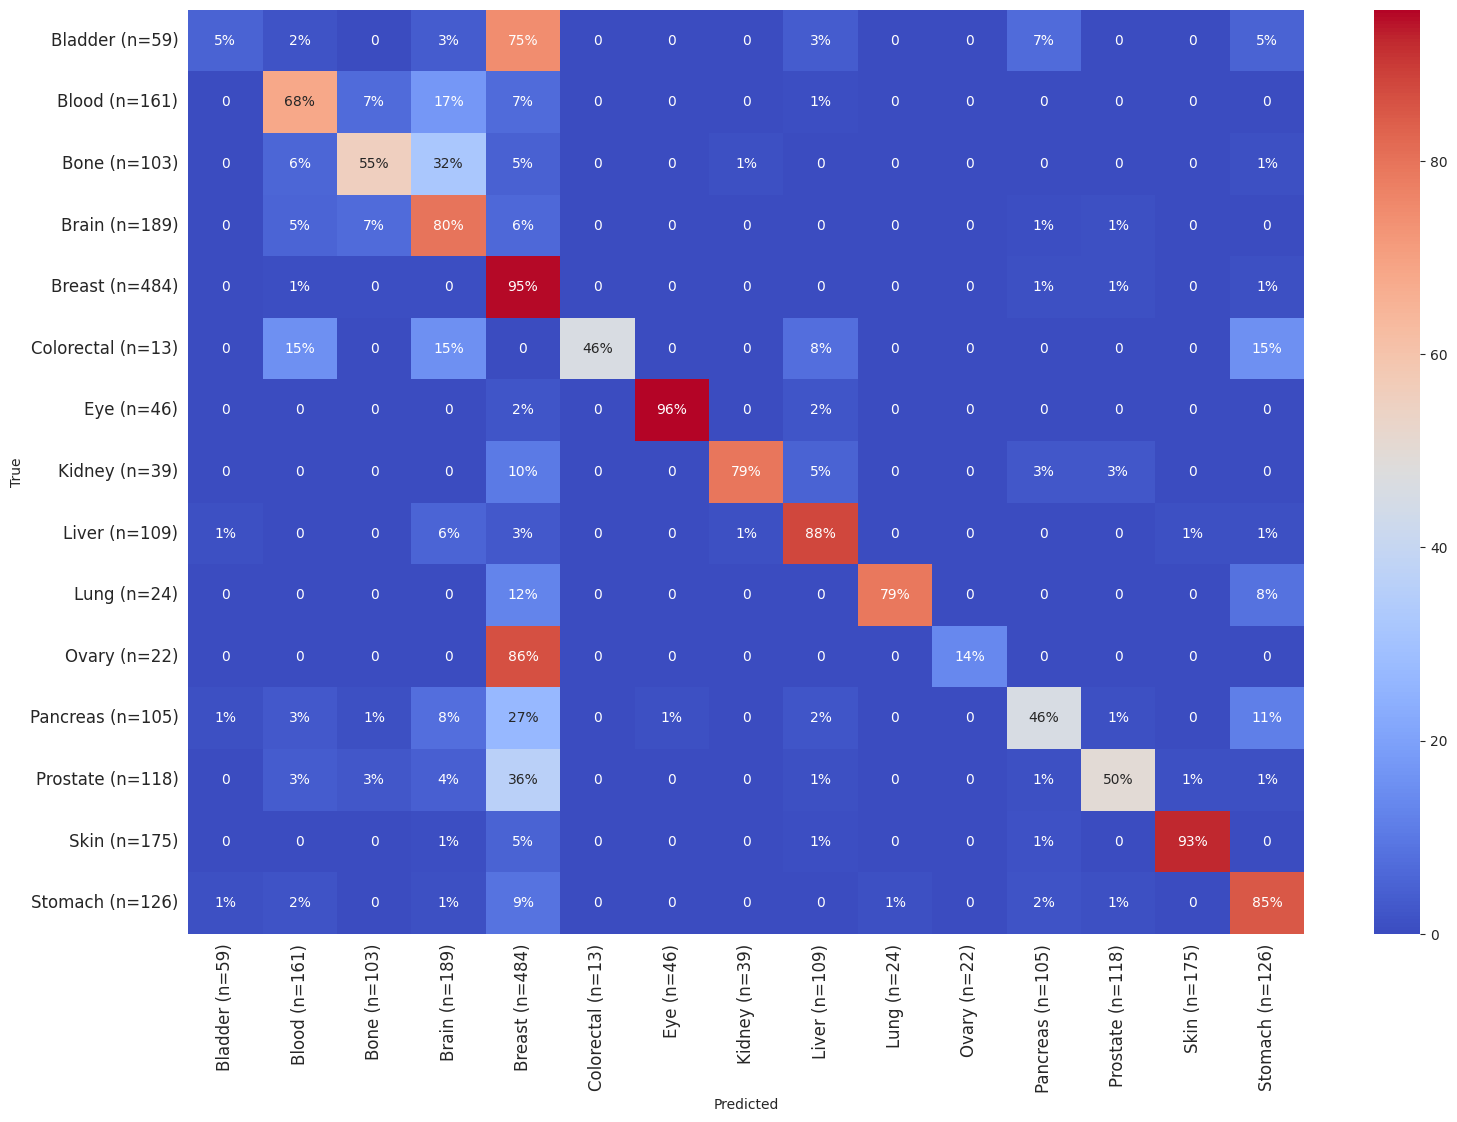

BALANCE ACCURACY: 0.6502292734659422 +_ 0.006340721269887435 

MCC: 0.7302759025026184 +_ 0.014145161917144777 

KAPPA: 0.7241205120931332 +_ 0.014127886265272336 



In [34]:
# MUSE XAE primary types classification

scaler=MinMaxScaler()

X=exp_extended_primary[exp_extended_primary.index.value_counts()>=10]
X=scaler.fit_transform(X)
y=exp_extended_primary[exp_extended_primary.index.value_counts()>=10].index

c=classification_from_representation(X,y)

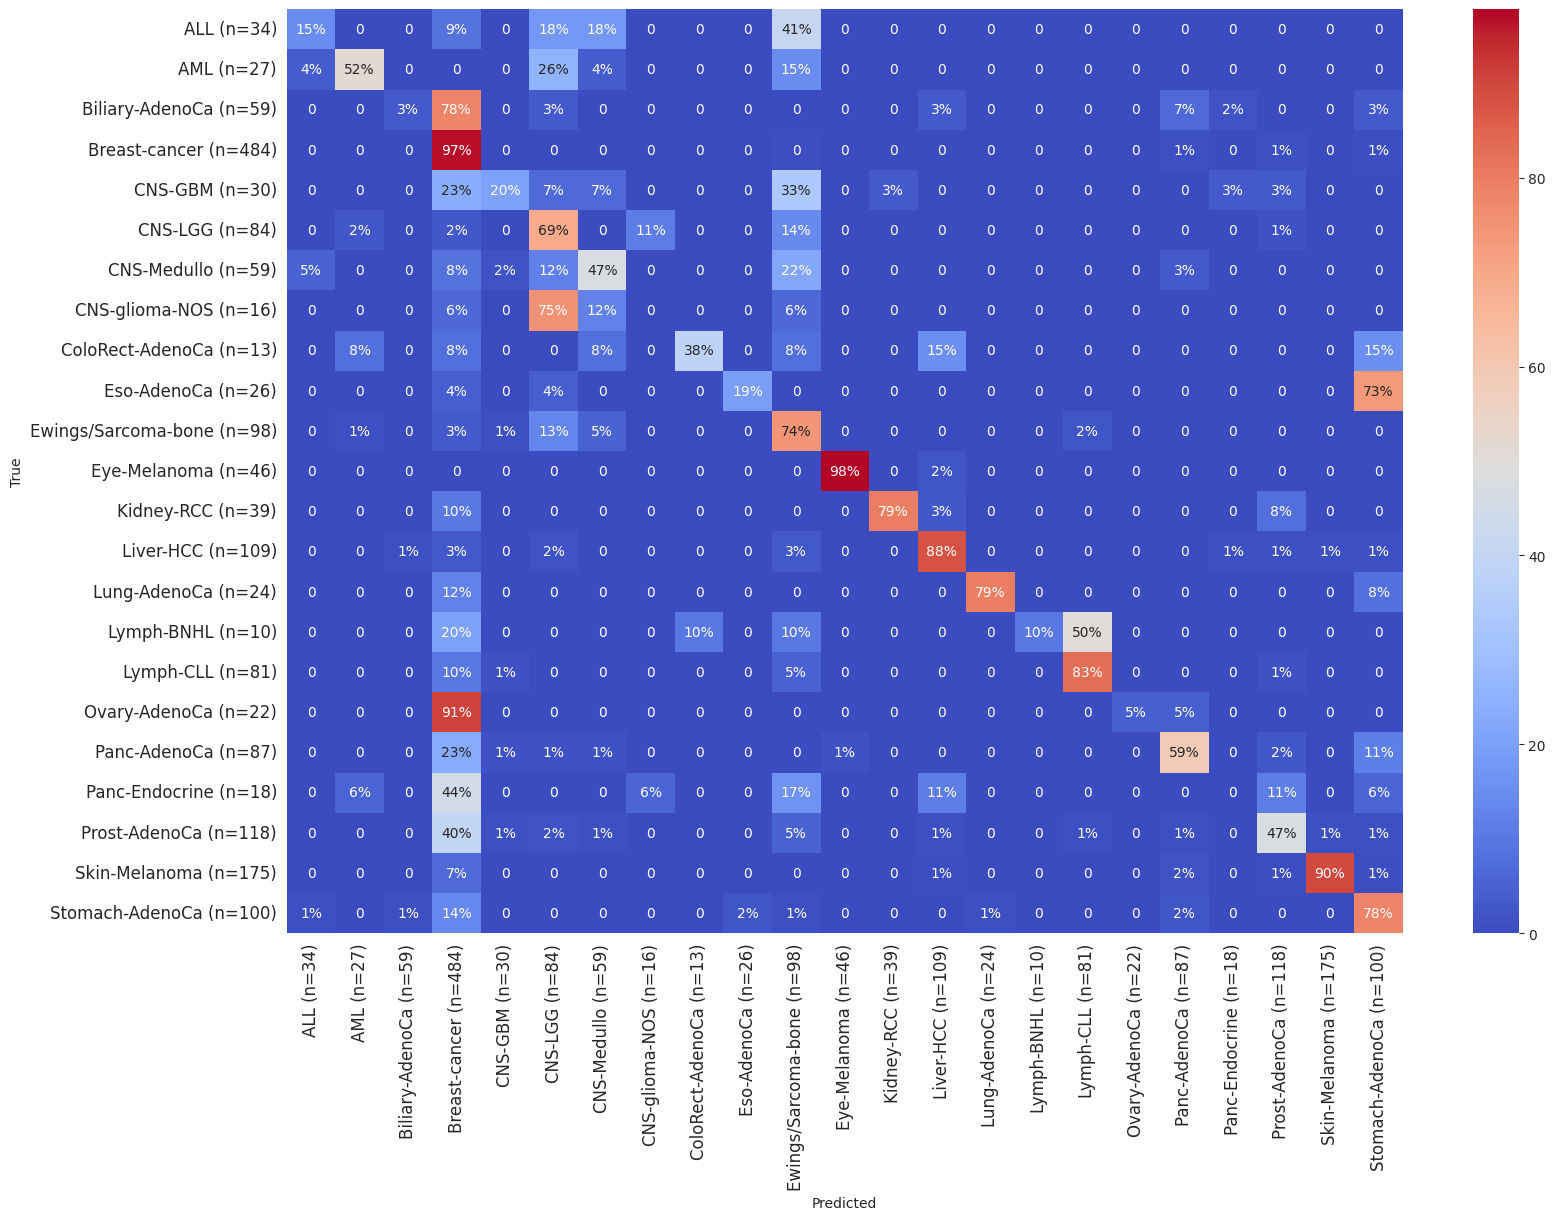

BALANCE ACCURACY: 0.5015934834960195 +_ 0.03635481281705113 

MCC: 0.681406221969954 +_ 0.02524658550847589 

KAPPA: 0.6741099579685577 +_ 0.026012266458155194 



In [35]:
# MUSE XAE subtypes classification

X=df_exp_extended_clean[df_exp_extended_clean.index.value_counts()>=10]
X=scaler.fit_transform(X)
y=df_exp_extended_clean[df_exp_extended_clean.index.value_counts()>=10].index

c=classification_from_representation(X,y)

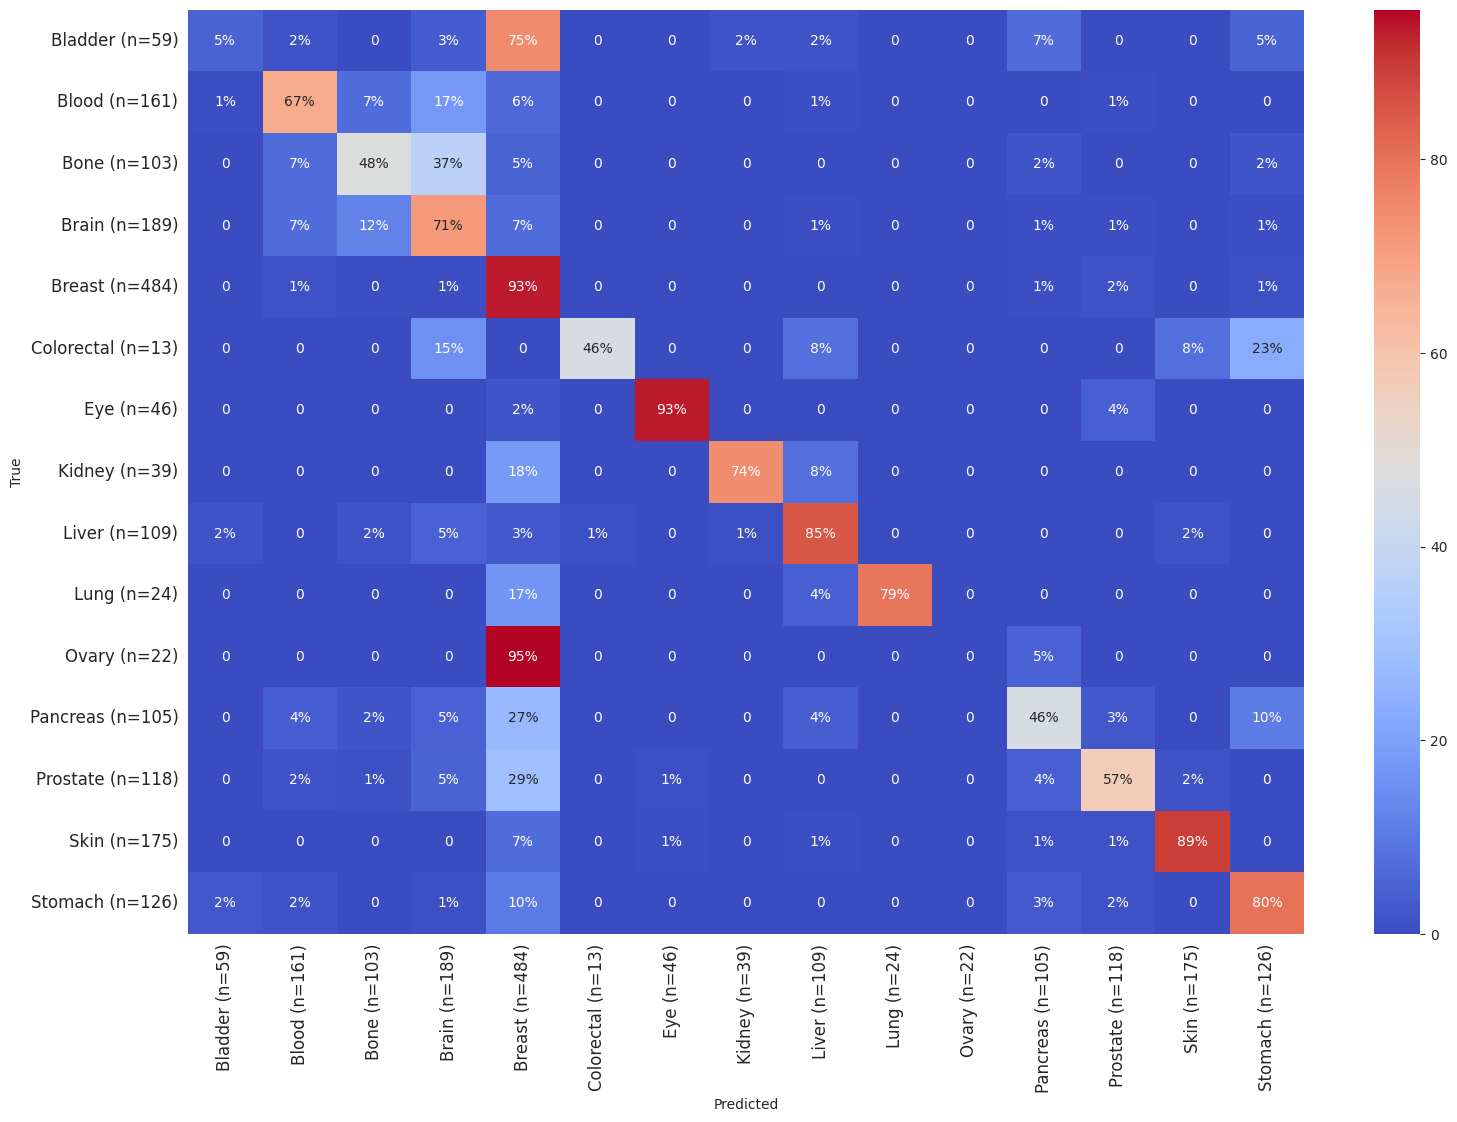

BALANCE ACCURACY: 0.6212378440700742 +_ 0.01905081681846035 

MCC: 0.6979966868094137 +_ 0.020965803817966398 

KAPPA: 0.6926857994443096 +_ 0.020440984962848928 



In [36]:
# Sigprofiler Extractor primary types

df_exp_extended=pd.read_csv('./Tools/SBS96_De-Novo_Activities_refit_Extended.txt',sep='\t').set_index('Samples')
df_exp_extended_clean_sig=df_exp_extended[~df_exp_extended.index.isin(sarcomab_to_remove)]

# extract types without code and merge Ewings/Sarcomabone
df_exp_extended_clean_sig.index=[typ.split(':')[0] for typ in df_exp_extended_clean_sig.index]

new_index = df_exp_extended_clean_sig.index.map(rename_index)

# assign new index
df_exp_extended_clean_sig.index = new_index
df_extended_clean.columns=df_exp_extended_clean_sig.index

primary_types_list=[]
for cancer in df_extended_clean.columns:
    if '-' in cancer: primary_types_list.append(cancer.split('-')[0])
    else: primary_types_list.append(cancer)

# primary tumor types

extended_primary=df_extended_clean.copy()
extended_primary.columns=primary_types_list
extended_primary=extended_primary.rename(columns=rep)
# exposures

exp_extended_primary=df_exp_extended_clean_sig.copy()
exp_extended_primary.index=extended_primary.columns
                
X=exp_extended_primary[exp_extended_primary.index.value_counts()>=10]
X=scaler.fit_transform(X)
y=exp_extended_primary[exp_extended_primary.index.value_counts()>=10].index

c=classification_from_representation(X,y)

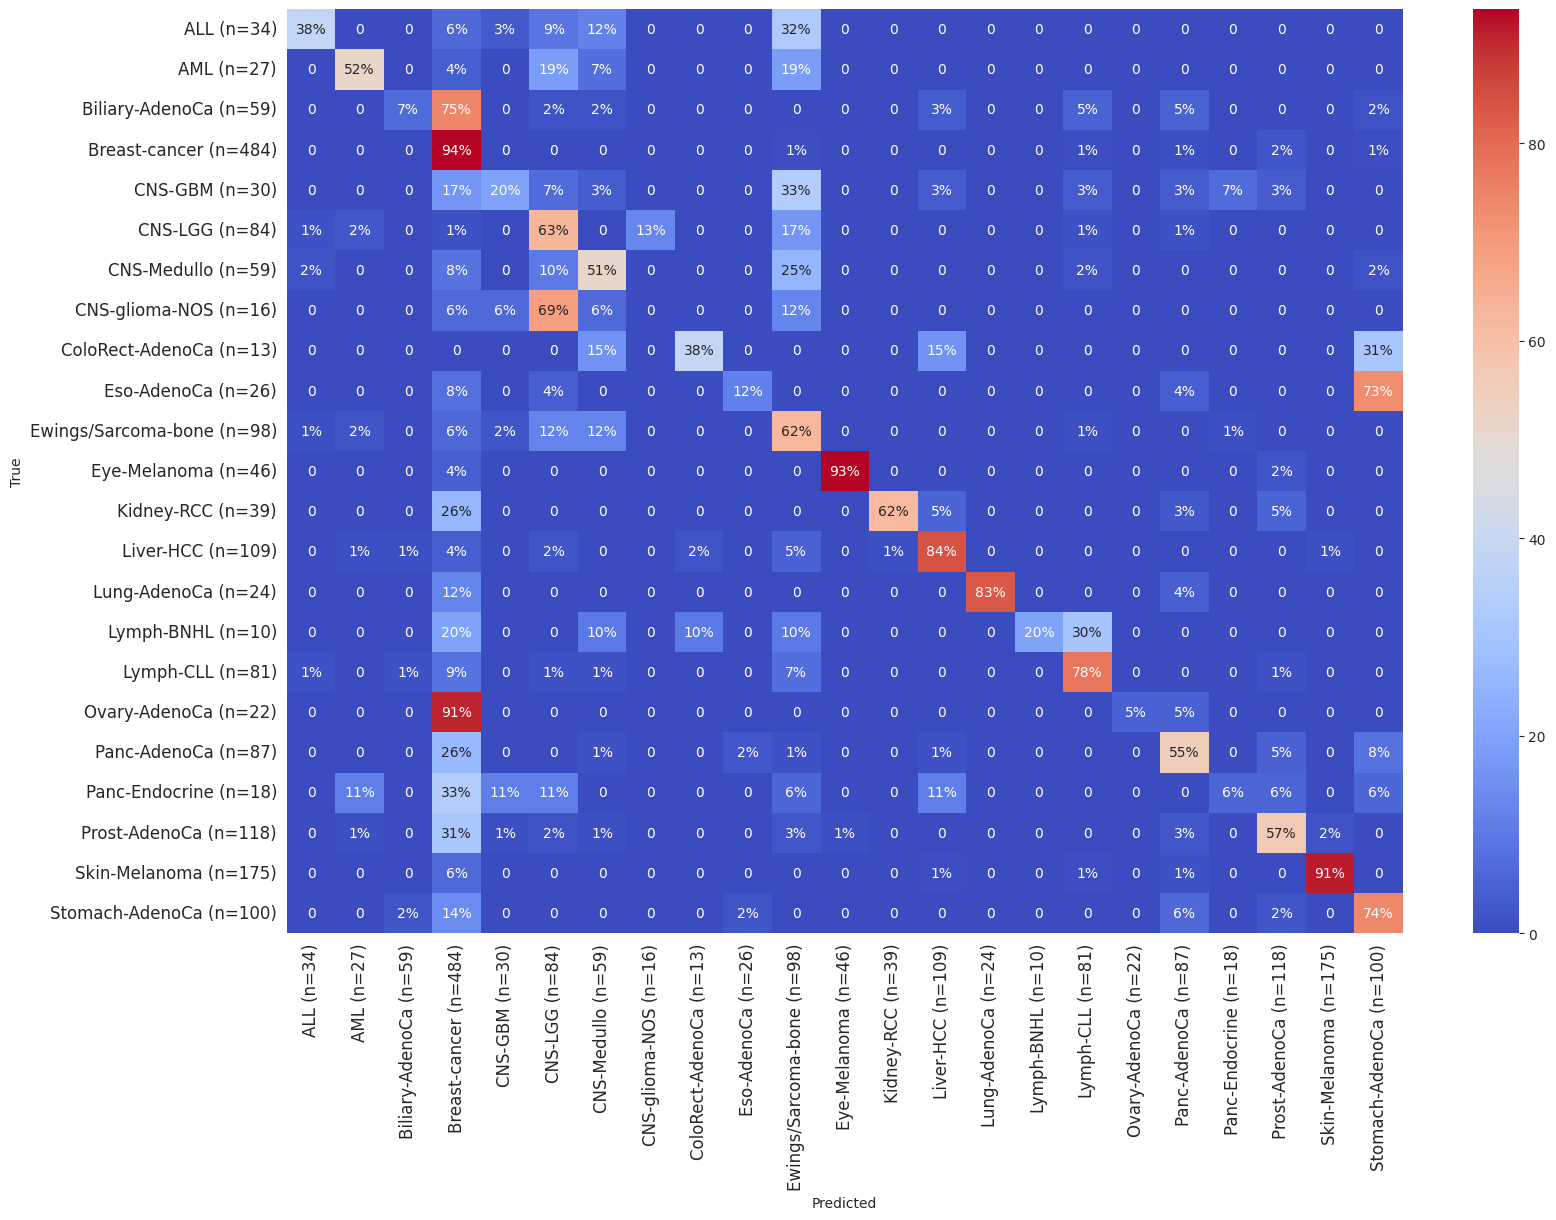

BALANCE ACCURACY: 0.49866742627135763 +_ 0.025734426661029167 

MCC: 0.661863276261377 +_ 0.01602826102832128 

KAPPA: 0.6559306387802553 +_ 0.017850491738320543 



In [37]:
# SigProfilerExtractor subtypes classification

X=df_exp_extended_clean_sig[df_exp_extended_clean_sig.index.value_counts()>=10]
X=scaler.fit_transform(X)
y=df_exp_extended_clean_sig[df_exp_extended_clean_sig.index.value_counts()>=10].index

c=classification_from_representation(X,y)

# Signatures Matching

In [38]:
# MUSE-XAE matched signatures with COSMIC and Signal Databases
# NB in the paper signatures are called MUSE-SBS A , MUSE-SBS B etc. here we use SBS_AE_1, SBS_AE_2 and so on 

MUSE_sig_extended=pd.read_csv('Experiments//WGS_extended/Suggested_SBS_De_Novo/MUSE_SBS.csv').iloc[:,1:]
SigProfiler_sig_extended=pd.read_csv('./Tools/SigProfilerExtractor_Extended_cohort/SBS96_De-Novo_Signatures.txt',sep='\t').iloc[:,1:]

Muse_match_cosmic_extended=stat_similarity(MUSE_sig_extended,COSMIC_sig,columns=['SBS MUSE-XAE','SBS COSMIC'])
Muse_match_signal_extended=stat_similarity(MUSE_sig_extended,Signal_sig,columns=['SBS MUSE-XAE','SBS Signal'])

df_cosmic_signal_extended=pd.concat([Muse_match_cosmic_extended.set_index('SBS MUSE-XAE'),Muse_match_signal_extended.set_index('SBS MUSE-XAE')],axis=1)
df_cosmic_signal_extended.columns=['COSMIC','Cosmic Similarity','SIGNAL','Signal Similarity']
df_cosmic_signal_extended.reset_index().round(2)


SBS MUSE-XAE  COSMIC  Cosmic Similarity  SIGNAL  Signal Similarity
0     MUSE-SBST  SBS22a               0.99      23               0.99
1     MUSE-SBSK   SBS7a               0.98       6               0.99
2     MUSE-SBSO    SBS2               0.98       1               0.97
3     MUSE-SBSR   SBS58               0.97     111               0.57
4     MUSE-SBSQ   SBS43               0.97      49               0.49
5     MUSE-SBSV   SBS44               0.96      34               0.88
6     MUSE-SBSU   SBS38               0.95      33               0.92
7     MUSE-SBSH  SBS17b               0.94      18               0.99
8     MUSE-SBSB   SBS13               0.92      14               0.99
9     MUSE-SBSF   SBS57               0.91      37               0.91
10    MUSE-SBSL   SBS39               0.91       2               0.75
11    MUSE-SBSI   SBS36               0.91      20               0.86
12    MUSE-SBSD   SBS26               0.89      73               0.89
13    MUSE-SBSC   SBS19               0.86      24               0.92
14    MUSE-SBSE    SBS1               0.85      46               0.86
15    MUSE-SBSG   SBS12               0.84      17               0.82
16    MUSE-SBSN   SBS34               0.84      93               0.76
17    MUSE-SBSM    SBS6               0.83       0               0.90
18    MUSE-SBSJ   SBS24               0.82      25               0.77
19    MUSE-SBSA    SBS9               0.75       9               0.90
20    MUSE-SBSS    SBS8               0.75       8               0.74
21    MUSE-SBSW    SBS5               0.72       4               0.75
22    MUSE-SBSP   SBS32               0.67      30               0.73

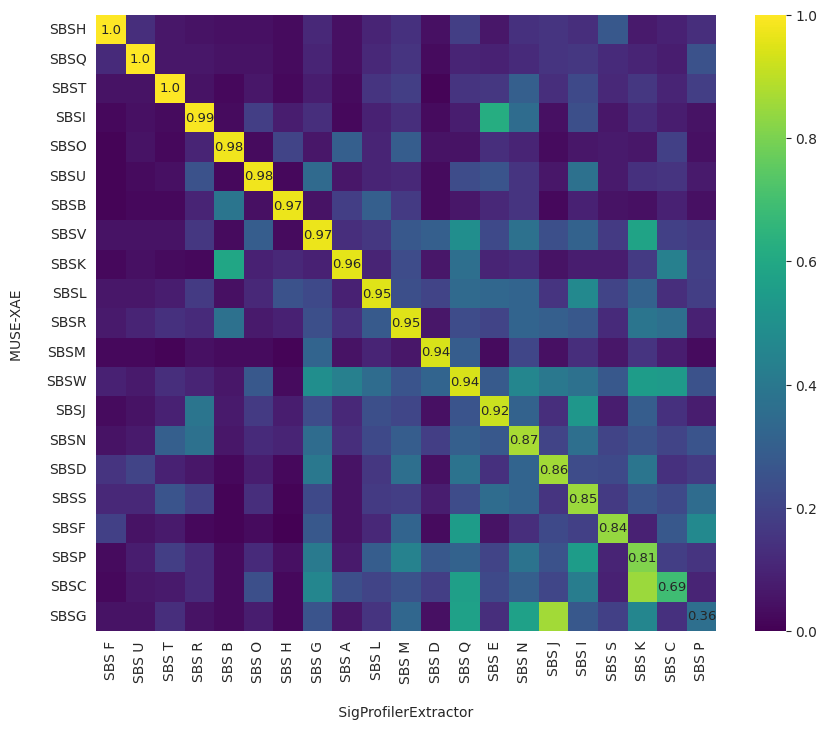

In [39]:
SigProfiler_match_muse_extended=stat_similarity(MUSE_sig_extended,SigProfiler_sig_extended,columns=['SBS MUSE-XAE','SBS SigProfilerExtractor'])
muse_ordered_sig_plot_extended=MUSE_sig_extended[SigProfiler_match_muse_extended['SBS MUSE-XAE']].T
Sigprof_ordered_sig_plot_extended=SigProfiler_sig_extended[SigProfiler_match_muse_extended['SBS SigProfilerExtractor']].T

Sigprof_ordered_sig_plot_extended.index=pd.Series(Sigprof_ordered_sig_plot_extended.index).apply(lambda x: x[:3]+' '+x[-1])
# Estrazione del numero dall'ID e conversione in lettera
muse_ordered_sig_plot_extended.index= pd.Series(muse_ordered_sig_plot_extended.index).apply(lambda x:x.split('-')[-1])


cosine_wgs=np.round(cosine_similarity(muse_ordered_sig_plot_extended,Sigprof_ordered_sig_plot_extended),2)
plt.figure(figsize=(10,8))
ax_wgs=sns.heatmap(np.round(cosine_similarity(muse_ordered_sig_plot_extended,Sigprof_ordered_sig_plot_extended),2),yticklabels=muse_ordered_sig_plot_extended.index,xticklabels=Sigprof_ordered_sig_plot_extended.index,cmap='viridis');
ax_wgs.set_xlabel('\n SigProfilerExtractor \n');
ax_wgs.set_ylabel('MUSE-XAE \n');

for i in range(len(cosine_pcawg)):
    ax_wgs.text(i+0.5, i+0.5, cosine_wgs[i, i], ha='center', va='center',fontsize=9.5)

### Plotting signatures exposures for three unmatched signatures in the WGS extended cohort

In [40]:
def dist_exposures_tumours(exposures,signature,label_sig='A',save_to=None):
    
    plt.figure(figsize=(12, 6))

    df = exposures.copy()
    df = df.reset_index()
    df = df.rename(columns={'index': 'Tumor_Type'})
    tumor_types = df.Tumor_Type.unique()

    # Set the aesthetics for the plots
    sns.set_theme(style="whitegrid")

    # Filter the dataframe to include only rows where 'SBS_AE_1' > 0
    filtered_df = df[df[signature] > 0]

    # Calculate N (count > 0) and M (total tumors) for each tumor type
    n_counts = filtered_df.groupby('Tumor_Type')[signature].count()
    total_counts = df.groupby('Tumor_Type')[signature].count()
    fractions = n_counts / total_counts

    # Sort tumor types and the plot by the median 
    sorted_tumor_types = filtered_df.groupby('Tumor_Type')[signature].median().sort_values().index
    filtered_df['Tumor_Type'] = pd.Categorical(filtered_df['Tumor_Type'], categories=sorted_tumor_types, ordered=True)
    filtered_df = filtered_df.sort_values(by='Tumor_Type')

    # Create a boxplot for the filtered data
    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(x='Tumor_Type', y=signature, data=filtered_df,showfliers=False)

    # Add fraction labels to the x-axis
    for i, tumor_type in enumerate(sorted_tumor_types):
        label = fr"$\frac{{{n_counts[tumor_type]}}}{{{total_counts[tumor_type]}}}$"
        ax.text(i, -0.12, label, ha='center', va='bottom', transform=ax.get_xaxis_transform(),rotation=0,fontsize=15)

    ax.text(0.01, 0.94, f'MUSE-SBS{label_sig}', transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', ha='left')
    #ax.set_yscale('log')
    ax.set_ylabel(f'Count of SBS  mutations')
    ax.xaxis.set_ticks_position('top')
    ax.set_xlabel('')

    plt.xticks(rotation=90)

    plt.tight_layout()
    if save_to: plt.savefig(save_to,dpi=400)
    plt.show()

<Figure size 1200x600 with 0 Axes>

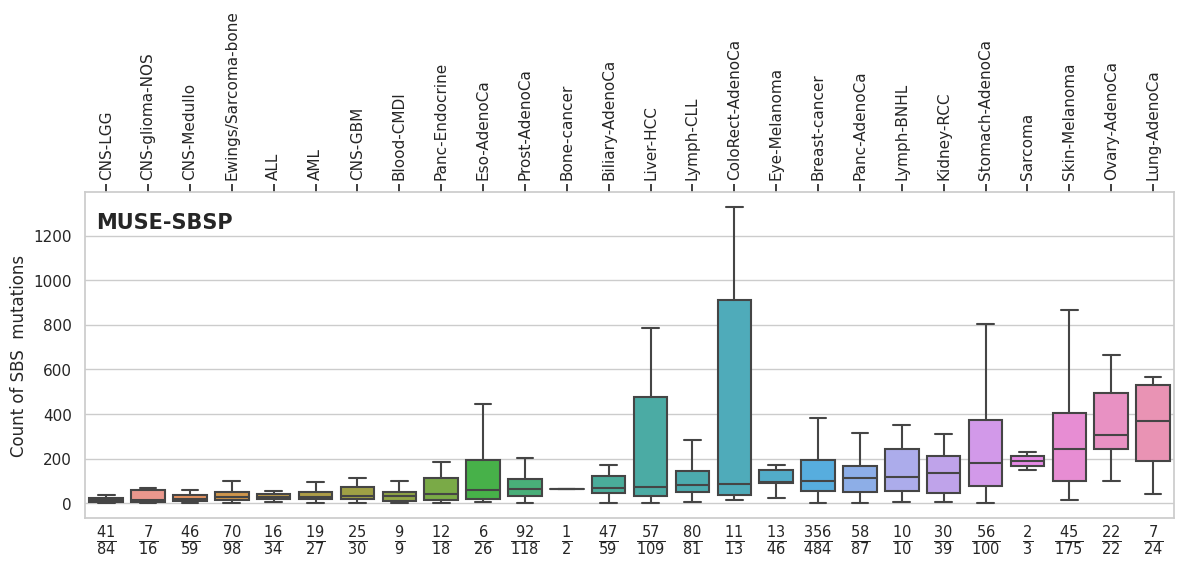

In [41]:
dist_exposures_tumours(df_exp_extended_clean,signature='MUSE-SBSP',label_sig='P');

<Figure size 1200x600 with 0 Axes>

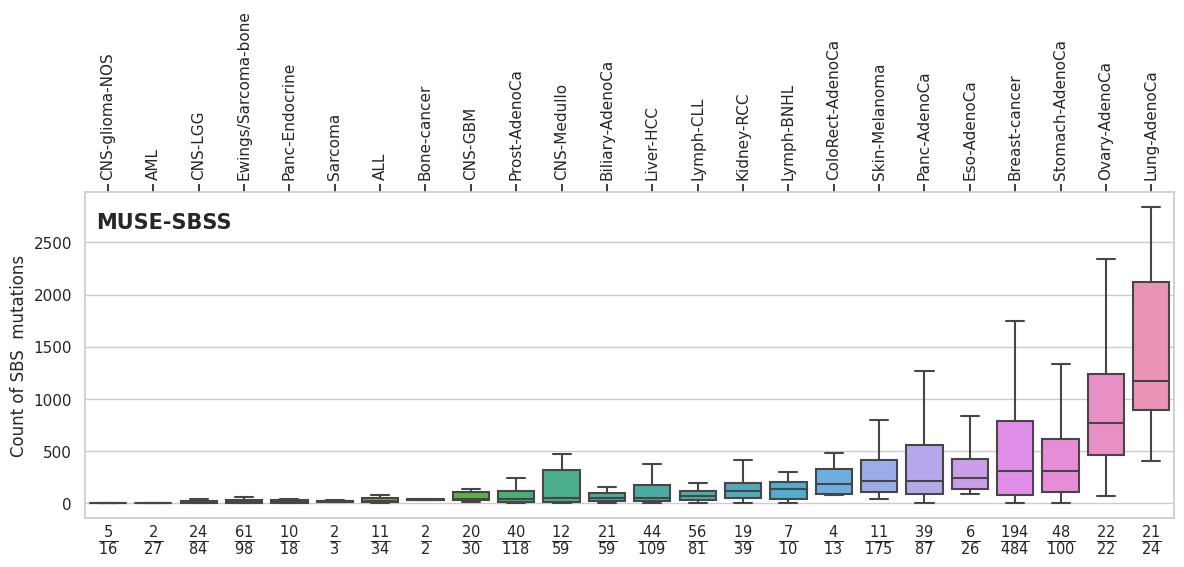

In [42]:
dist_exposures_tumours(df_exp_extended_clean,signature='MUSE-SBSS',label_sig='S');

<Figure size 1200x600 with 0 Axes>

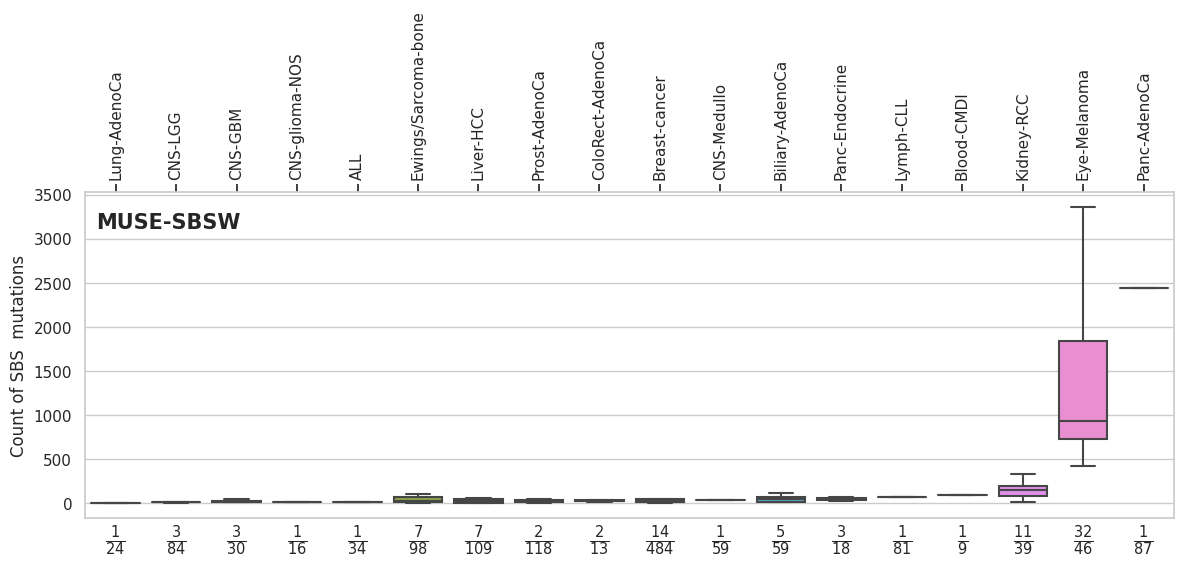

In [43]:
dist_exposures_tumours(df_exp_extended_clean,signature='MUSE-SBSW',label_sig='W');

In [44]:
Eye_Melanoma=pd.read_csv('./Experiments/Eye-Melanoma/Suggested_SBS_De_Novo/MUSE_SBS.csv').set_index('Type')

In [45]:
stat_similarity(pd.DataFrame(muse_sig_extended['MUSE-SBSW']),pd.DataFrame(Eye_Melanoma),columns=['Pan Cancer','Single Tissue'])

Pan Cancer Single Tissue  Cosine Similarity
0  MUSE-SBSW     MUSE-SBSB           0.936494